# This notebook is for Mahalanobis distance (single sensor at a time) results on train & two test sets (normal & faulty vehicle) for rough road surface

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import math
import csv

# Import and read train (subset of Feb - normal vehicle) set

In [58]:
data_vib1 = pd.read_csv("Input_Data_Files/RoughDataTrain.csv", index_col=0)
data_vib1

FR_LH [m/s2]  FR_RH [m/s2]  RR_LH [m/s2]  \
DateTime                                                            
2020-02-25 16:40:05.600      3.076945      2.005210      0.794605   
2020-02-25 16:40:05.605     -0.643661     -1.515605      1.031323   
2020-02-25 16:40:05.610      2.836121      3.578015      0.940638   
2020-02-25 16:40:05.615      0.456141     -1.551423      1.076140   
2020-02-25 16:40:05.620      0.245845      0.819562      1.121251   
...                               ...           ...           ...   
2020-02-25 15:25:44.810     -2.441289     -0.014932     -0.664579   
2020-02-25 15:25:44.815      1.175209      8.271926     -1.097748   
2020-02-25 15:25:44.820     -2.777858      3.400182     -2.190061   
2020-02-25 15:25:44.825     11.024702      5.391313     -1.933210   
2020-02-25 15:25:44.830     -3.310457      5.294851     -4.020750   

                         RR_RH [m/s2]  Cabin [m/s2]  
DateTime                                             
2020-02-25 16:40:05.600      0.253525      0.680249  
2020-02-25 16:40:05.605      0.139600      0.285827  
2020-02-25 16:40:05.610      0.474731      0.223586  
2020-02-25 16:40:05.615      0.735006      0.603429  
2020-02-25 16:40:05.620      0.500910     -0.625381  
...                               ...           ...  
2020-02-25 15:25:44.810      1.031195      3.263141  
2020-02-25 15:25:44.815      0.689503      1.028962  
2020-02-25 15:25:44.820      1.966211     -3.580245  
2020-02-25 15:25:44.825     -0.806204     -2.816862  
2020-02-25 15:25:44.830     -2.378596      1.591644  

[164932 rows x 5 columns]

array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>], dtype=object)

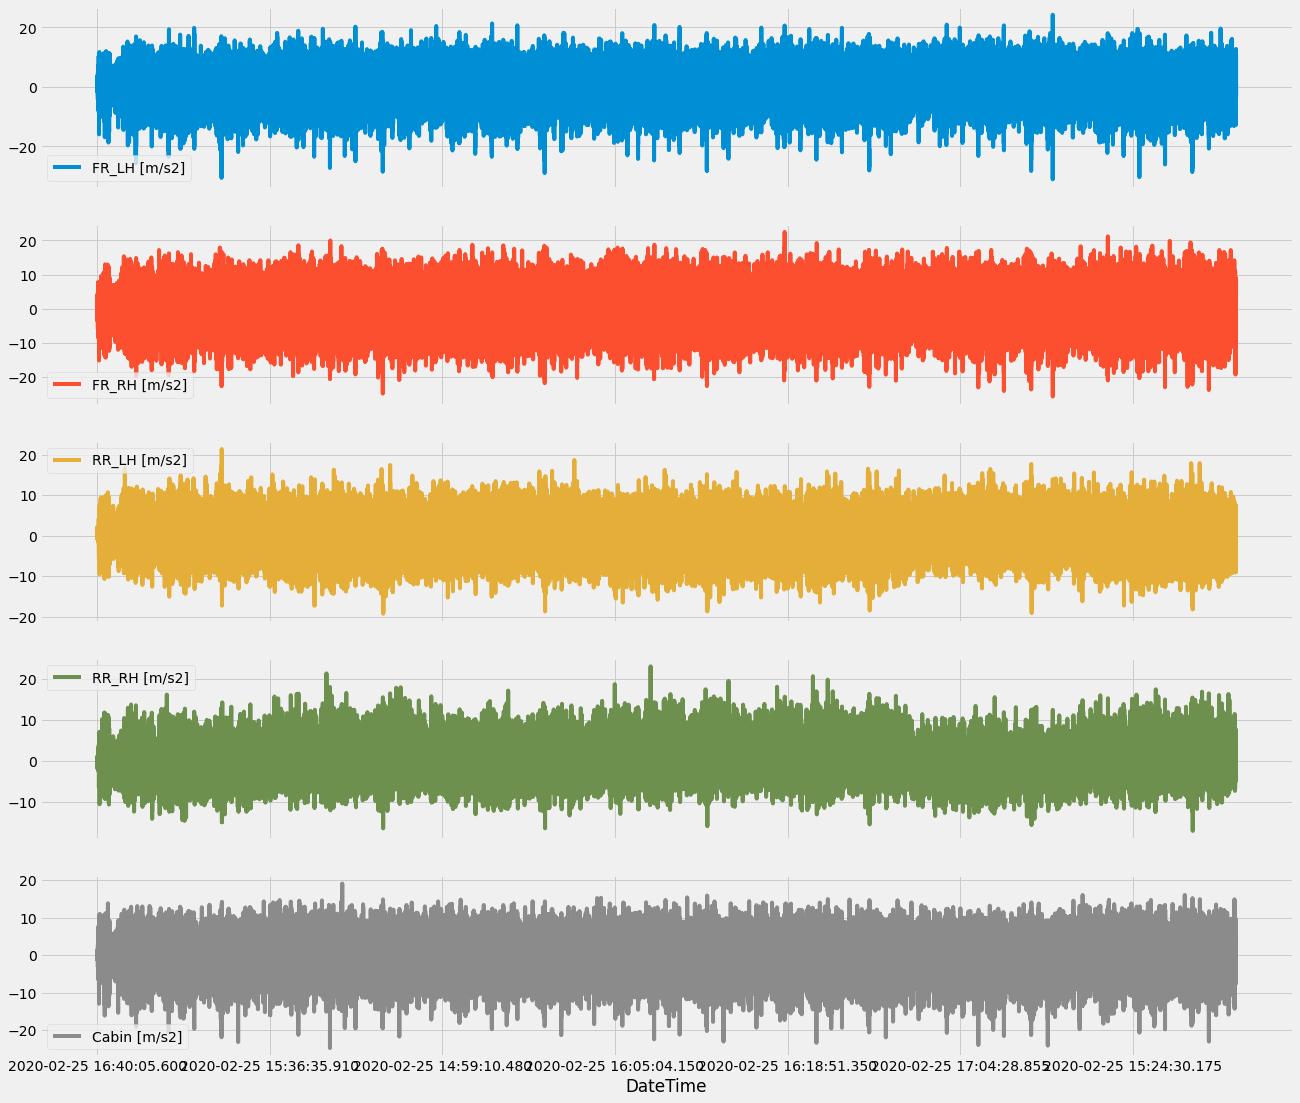

In [59]:
plt.style.use('fivethirtyeight')
data_vib1.plot(figsize=(20,18), subplots=True)

# Time domain feature extraction (7 features) function

In [4]:
def time_domain_features(test1,w,overlap):
    columns = test1.columns
    for c in range (len(columns)):
        for i in range(0,test1.shape[0]-(w-1),overlap):
            test1.loc[test1.index[i+w-1],'mean_'+str(c)] = test1.iloc[i:i+w,c].mean()
            test1.loc[test1.index[i+w-1],'var_'+str(c)] = test1.iloc[i:i+w,c].var()
            test1.loc[test1.index[i+w-1],'skew_'+str(c)] = test1.iloc[i:i+w,c].skew()
            test1.loc[test1.index[i+w-1],'kurtosis_'+str(c)] = test1.iloc[i:i+w,c].kurtosis()
            test1.loc[test1.index[i+w-1],'peak_'+str(c)] = np.max(np.abs(test1.iloc[i:i+w,c]))
            test1.loc[test1.index[i+w-1],'rms_'+str(c)] = np.sqrt(np.mean(np.square(test1.iloc[i:i+w,c])))
            test1.loc[test1.index[i+w-1],'crest_'+str(c)] = (np.max(np.abs(test1.iloc[i:i+w,c])))/(np.sqrt(np.mean(np.square(test1.iloc[i:i+w,c]))))
    return (test1)

# Feature extraction (7 features for each sensor) of train set (total 35 features)

In [5]:
data_vib2 = time_domain_features(data_vib1,2000,250)
data_vib2

FR_LH [m/s2]  FR_RH [m/s2]  RR_LH [m/s2]  \
DateTime                                                            
2020-02-25 16:40:05.600      3.076945      2.005210      0.794605   
2020-02-25 16:40:05.605     -0.643661     -1.515605      1.031323   
2020-02-25 16:40:05.610      2.836121      3.578015      0.940638   
2020-02-25 16:40:05.615      0.456141     -1.551423      1.076140   
2020-02-25 16:40:05.620      0.245845      0.819562      1.121251   
...                               ...           ...           ...   
2020-02-25 15:25:44.810     -2.441289     -0.014932     -0.664579   
2020-02-25 15:25:44.815      1.175209      8.271926     -1.097748   
2020-02-25 15:25:44.820     -2.777858      3.400182     -2.190061   
2020-02-25 15:25:44.825     11.024702      5.391313     -1.933210   
2020-02-25 15:25:44.830     -3.310457      5.294851     -4.020750   

                         RR_RH [m/s2]  Cabin [m/s2]  mean_0  var_0  skew_0  \
DateTime                                                                     
2020-02-25 16:40:05.600      0.253525      0.680249     NaN    NaN     NaN   
2020-02-25 16:40:05.605      0.139600      0.285827     NaN    NaN     NaN   
2020-02-25 16:40:05.610      0.474731      0.223586     NaN    NaN     NaN   
2020-02-25 16:40:05.615      0.735006      0.603429     NaN    NaN     NaN   
2020-02-25 16:40:05.620      0.500910     -0.625381     NaN    NaN     NaN   
...                               ...           ...     ...    ...     ...   
2020-02-25 15:25:44.810      1.031195      3.263141     NaN    NaN     NaN   
2020-02-25 15:25:44.815      0.689503      1.028962     NaN    NaN     NaN   
2020-02-25 15:25:44.820      1.966211     -3.580245     NaN    NaN     NaN   
2020-02-25 15:25:44.825     -0.806204     -2.816862     NaN    NaN     NaN   
2020-02-25 15:25:44.830     -2.378596      1.591644     NaN    NaN     NaN   

                         kurtosis_0  peak_0  ...  peak_3  rms_3  crest_3  \
DateTime                                     ...                           
2020-02-25 16:40:05.600         NaN     NaN  ...     NaN    NaN      NaN   
2020-02-25 16:40:05.605         NaN     NaN  ...     NaN    NaN      NaN   
2020-02-25 16:40:05.610         NaN     NaN  ...     NaN    NaN      NaN   
2020-02-25 16:40:05.615         NaN     NaN  ...     NaN    NaN      NaN   
2020-02-25 16:40:05.620         NaN     NaN  ...     NaN    NaN      NaN   
...                             ...     ...  ...     ...    ...      ...   
2020-02-25 15:25:44.810         NaN     NaN  ...     NaN    NaN      NaN   
2020-02-25 15:25:44.815         NaN     NaN  ...     NaN    NaN      NaN   
2020-02-25 15:25:44.820         NaN     NaN  ...     NaN    NaN      NaN   
2020-02-25 15:25:44.825         NaN     NaN  ...     NaN    NaN      NaN   
2020-02-25 15:25:44.830         NaN     NaN  ...     NaN    NaN      NaN   

                         mean_4  var_4  skew_4  kurtosis_4  peak_4  rms_4  \
DateTime                                                                    
2020-02-25 16:40:05.600     NaN    NaN     NaN         NaN     NaN    NaN   
2020-02-25 16:40:05.605     NaN    NaN     NaN         NaN     NaN    NaN   
2020-02-25 16:40:05.610     NaN    NaN     NaN         NaN     NaN    NaN   
2020-02-25 16:40:05.615     NaN    NaN     NaN         NaN     NaN    NaN   
2020-02-25 16:40:05.620     NaN    NaN     NaN         NaN     NaN    NaN   
...                         ...    ...     ...         ...     ...    ...   
2020-02-25 15:25:44.810     NaN    NaN     NaN         NaN     NaN    NaN   
2020-02-25 15:25:44.815     NaN    NaN     NaN         NaN     NaN    NaN   
2020-02-25 15:25:44.820     NaN    NaN     NaN         NaN     NaN    NaN   
2020-02-25 15:25:44.825     NaN    NaN     NaN         NaN     NaN    NaN   
2020-02-25 15:25:44.830     NaN    NaN     NaN         NaN     NaN    NaN   

                         crest_4  
DateTime                          
2020-02-25 16:40:05.600      NaN  
2020-02-25 16:40

# Considering extracted features for each sensor value of train set (7 features at a time)

652
                           mean_0      var_0    skew_0  kurtosis_0     peak_0  \
DateTime                                                                        
2020-02-25 16:43:31.105  0.805269  17.273123 -0.270549    0.464985  18.691126   
2020-02-25 16:43:32.355  0.683561  16.839261 -0.223443    0.526853  18.691126   
2020-02-25 16:43:33.605  0.679160  15.455854 -0.152287    0.636960  18.691126   
2020-02-25 16:43:34.855  0.550703  14.714156 -0.130718    0.827209  18.691126   
2020-02-25 16:43:36.105  0.533184  13.564542 -0.142150    1.046993  18.691126   

                            rms_0   crest_0  
DateTime                                     
2020-02-25 16:43:31.105  4.232369  4.416233  
2020-02-25 16:43:32.355  4.159098  4.494034  
2020-02-25 16:43:33.605  3.988657  4.686070  
2020-02-25 16:43:34.855  3.874283  4.824409  
2020-02-25 16:43:36.105  3.720490  5.023835  


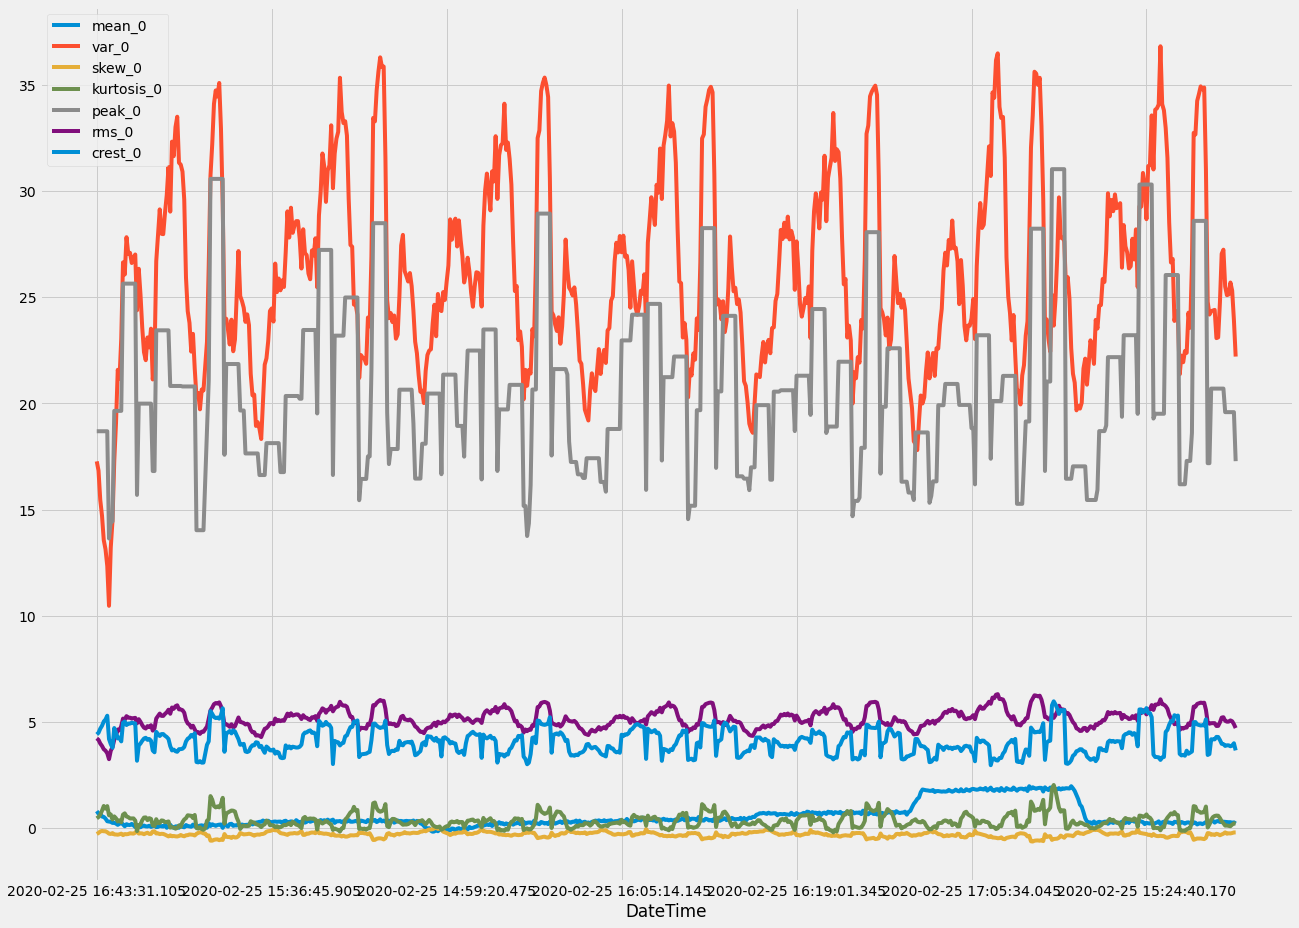

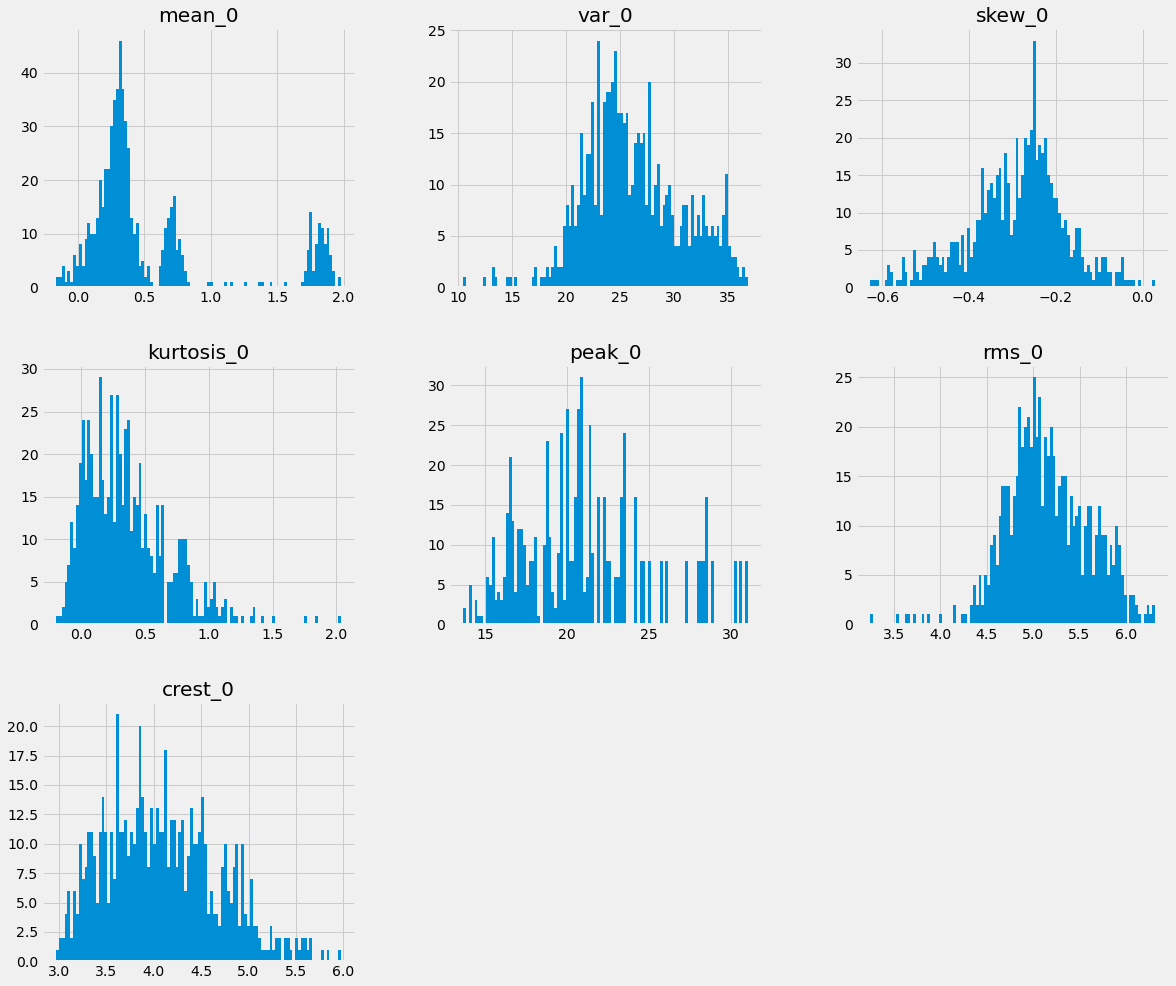

In [60]:
plt.style.use('fivethirtyeight')
data_vib_FR_LH = data_vib2.iloc[:,5:12]
data_vib_FR_LH = data_vib_FR_LH.dropna()
print(len(data_vib_FR_LH))
print(data_vib_FR_LH.head())
data_vib_FR_LH.plot(figsize=(20,15))
data_vib_FR_LH.hist(bins=100, figsize=(18,16))
plt.show()

652
                           mean_1      var_1    skew_1  kurtosis_1     peak_1  \
DateTime                                                                        
2020-02-25 16:43:31.105  0.294762  16.007497 -0.298229    0.314455  15.168739   
2020-02-25 16:43:32.355  0.216514  15.545511 -0.265701    0.409186  15.168739   
2020-02-25 16:43:33.605  0.247932  14.512545 -0.231261    0.519405  14.344440   
2020-02-25 16:43:34.855  0.180251  13.575810 -0.233603    0.751762  14.344440   
2020-02-25 16:43:36.105  0.188390  13.017090 -0.251565    0.849477  14.344440   

                            rms_1   crest_1  
DateTime                                     
2020-02-25 16:43:31.105  4.010783  3.781990  
2020-02-25 16:43:32.355  3.947736  3.842390  
2020-02-25 16:43:33.605  3.816642  3.758393  
2020-02-25 16:43:34.855  3.688023  3.889466  
2020-02-25 16:43:36.105  3.611935  3.971401  


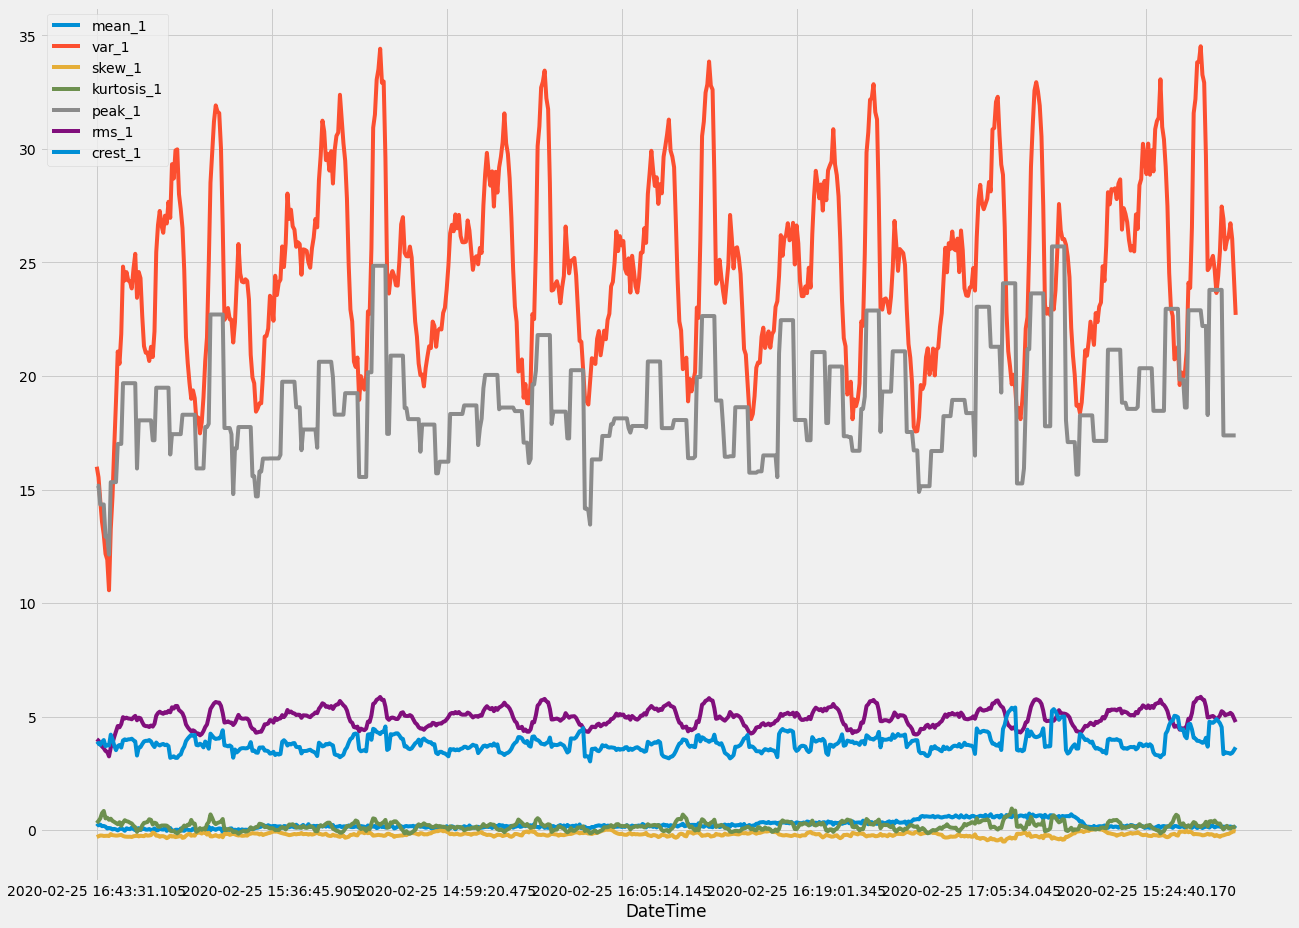

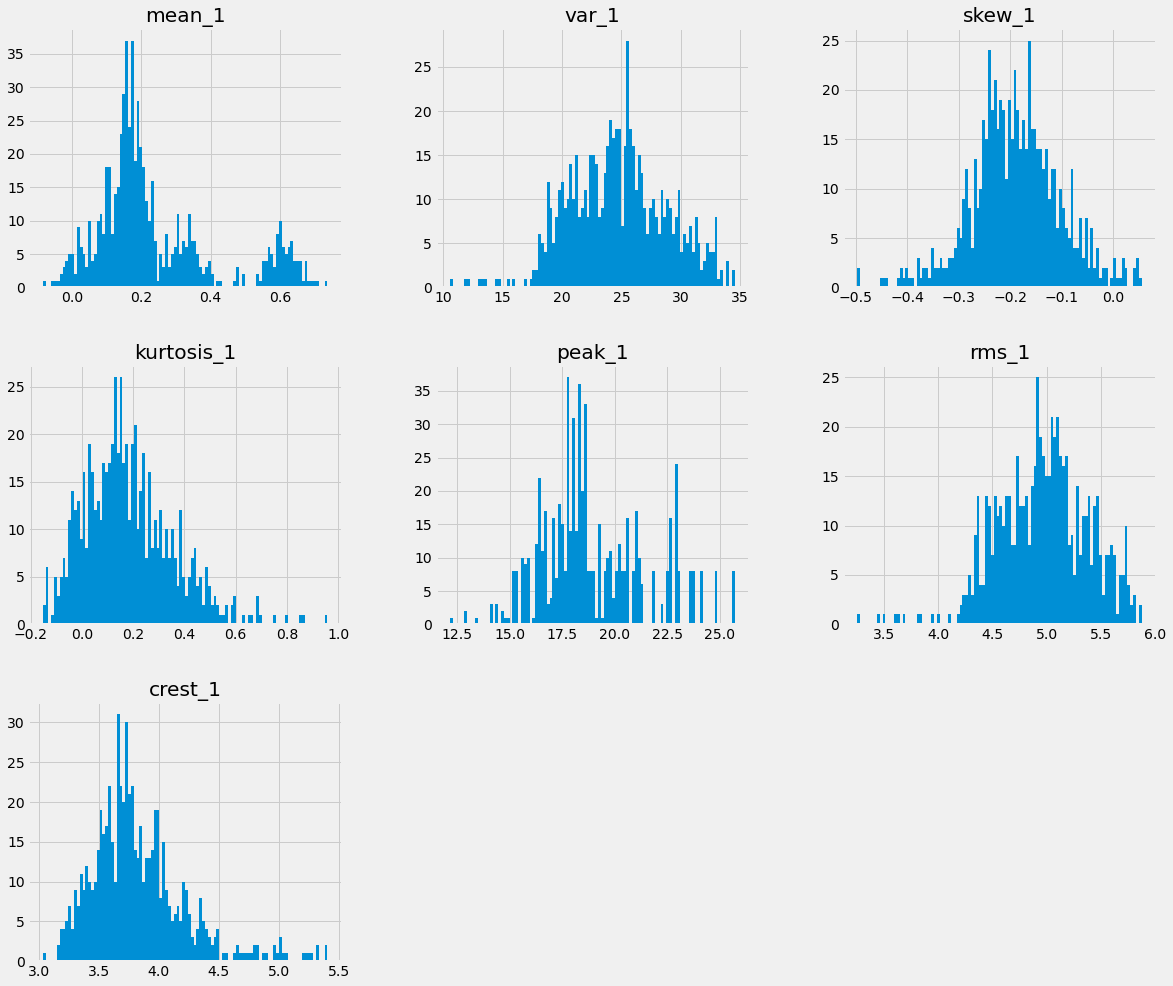

In [61]:
plt.style.use('fivethirtyeight')
data_vib_FR_RH = data_vib2.iloc[:,12:19]
data_vib_FR_RH = data_vib_FR_RH.dropna()
print(len(data_vib_FR_RH))
print(data_vib_FR_RH.head())
data_vib_FR_RH.plot(figsize=(20,15))
data_vib_FR_RH.hist(bins=100, figsize=(18,16))
plt.show()

652
                           mean_2      var_2    skew_2  kurtosis_2     peak_2  \
DateTime                                                                        
2020-02-25 16:43:31.105  0.434367  11.772672 -0.151346    0.217705  10.727784   
2020-02-25 16:43:32.355  0.422482  11.828261 -0.141863    0.185955  10.727784   
2020-02-25 16:43:33.605  0.463806  10.206951 -0.073364    0.464793  10.727784   
2020-02-25 16:43:34.855  0.426259   9.574521 -0.100590    0.661334  10.727784   
2020-02-25 16:43:36.105  0.518804   9.162830 -0.177397    0.873796  10.727784   

                            rms_2   crest_2  
DateTime                                     
2020-02-25 16:43:31.105  3.457667  3.102608  
2020-02-25 16:43:32.355  3.464223  3.096736  
2020-02-25 16:43:33.605  3.227532  3.323835  
2020-02-25 16:43:34.855  3.122728  3.435388  
2020-02-25 16:43:36.105  3.070408  3.493928  


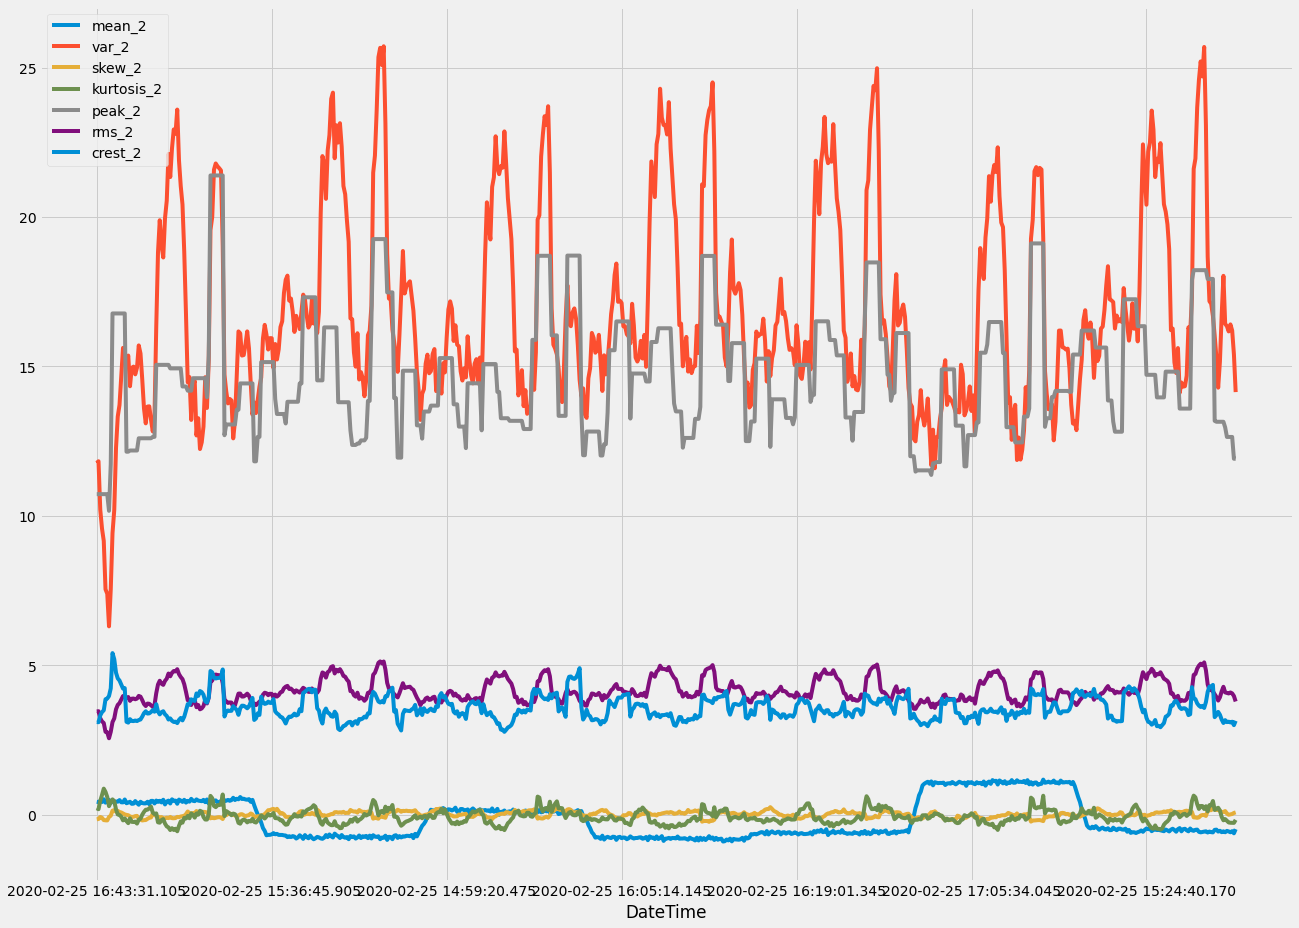

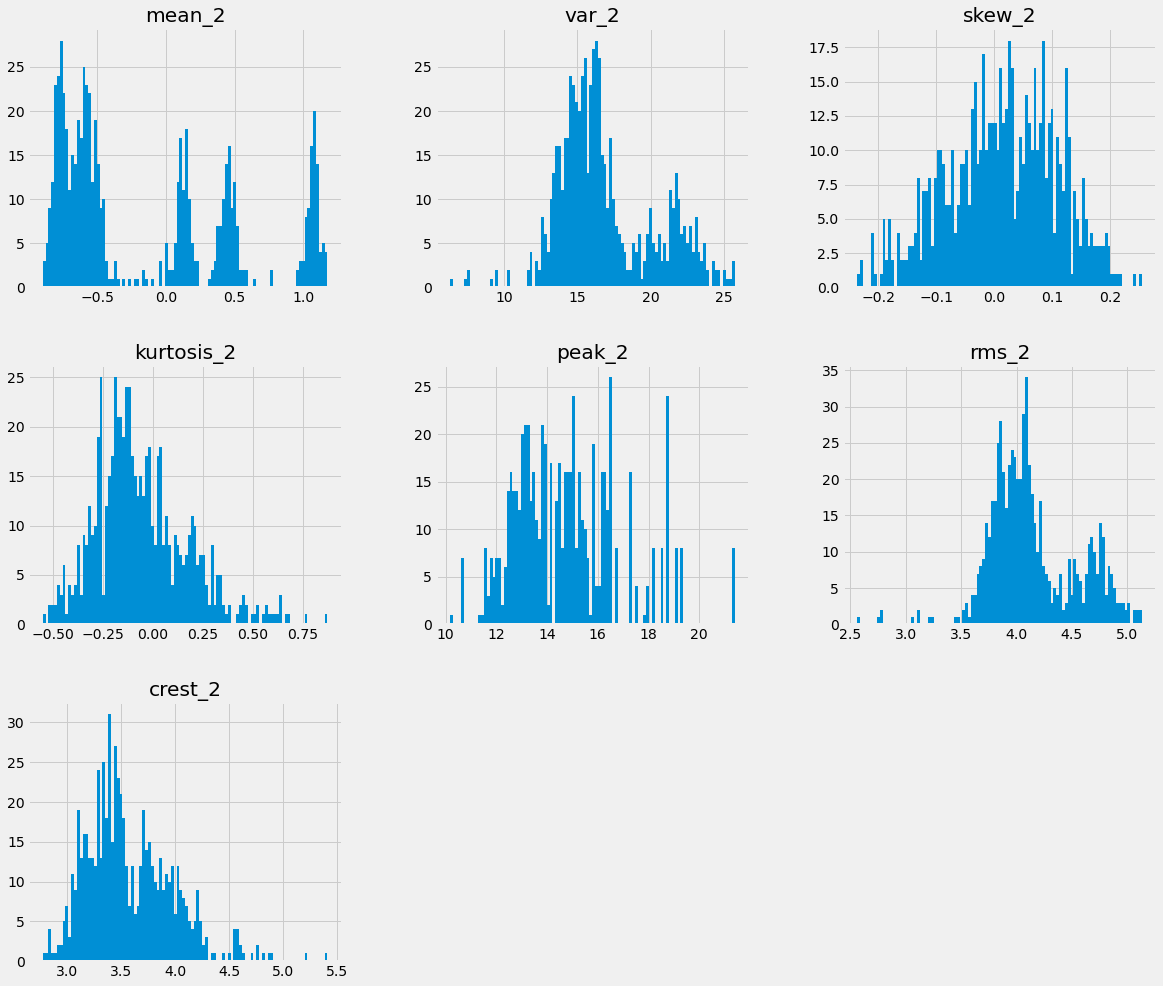

In [62]:
plt.style.use('fivethirtyeight')
data_vib_RR_LH = data_vib2.iloc[:,19:26]
data_vib_RR_LH = data_vib_RR_LH.dropna()
print(len(data_vib_RR_LH))
print(data_vib_RR_LH.head())
data_vib_RR_LH.plot(figsize=(20,15))
data_vib_RR_LH.hist(bins=100, figsize=(18,16))
plt.show()

652
                           mean_3      var_3    skew_3  kurtosis_3     peak_3  \
DateTime                                                                        
2020-02-25 16:43:31.105 -0.328956  10.741679 -0.024816    0.596733  11.846721   
2020-02-25 16:43:32.355 -0.363808  10.778368  0.002415    0.571157  11.846721   
2020-02-25 16:43:33.605 -0.341613   9.388478  0.114274    0.931521  11.846721   
2020-02-25 16:43:34.855 -0.411981   8.919655  0.106713    1.143189  11.846721   
2020-02-25 16:43:36.105 -0.354602   8.675956  0.072872    1.292990  11.846721   

                            rms_3   crest_3  
DateTime                                     
2020-02-25 16:43:31.105  3.293102  3.597435  
2020-02-25 16:43:32.355  3.302323  3.587390  
2020-02-25 16:43:33.605  3.082285  3.843486  
2020-02-25 16:43:34.855  3.014121  3.930407  
2020-02-25 16:43:36.105  2.966035  3.994128  


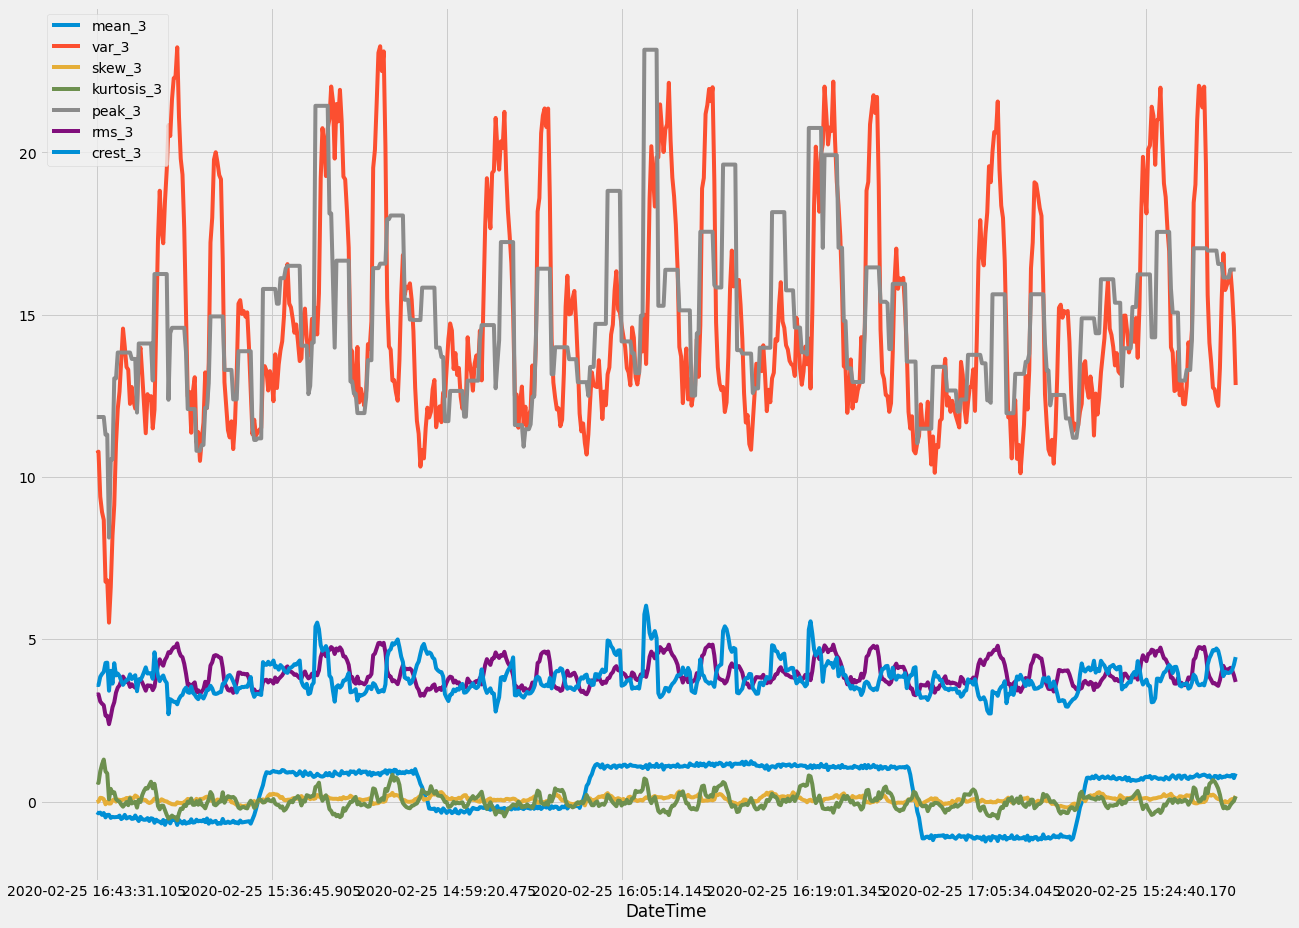

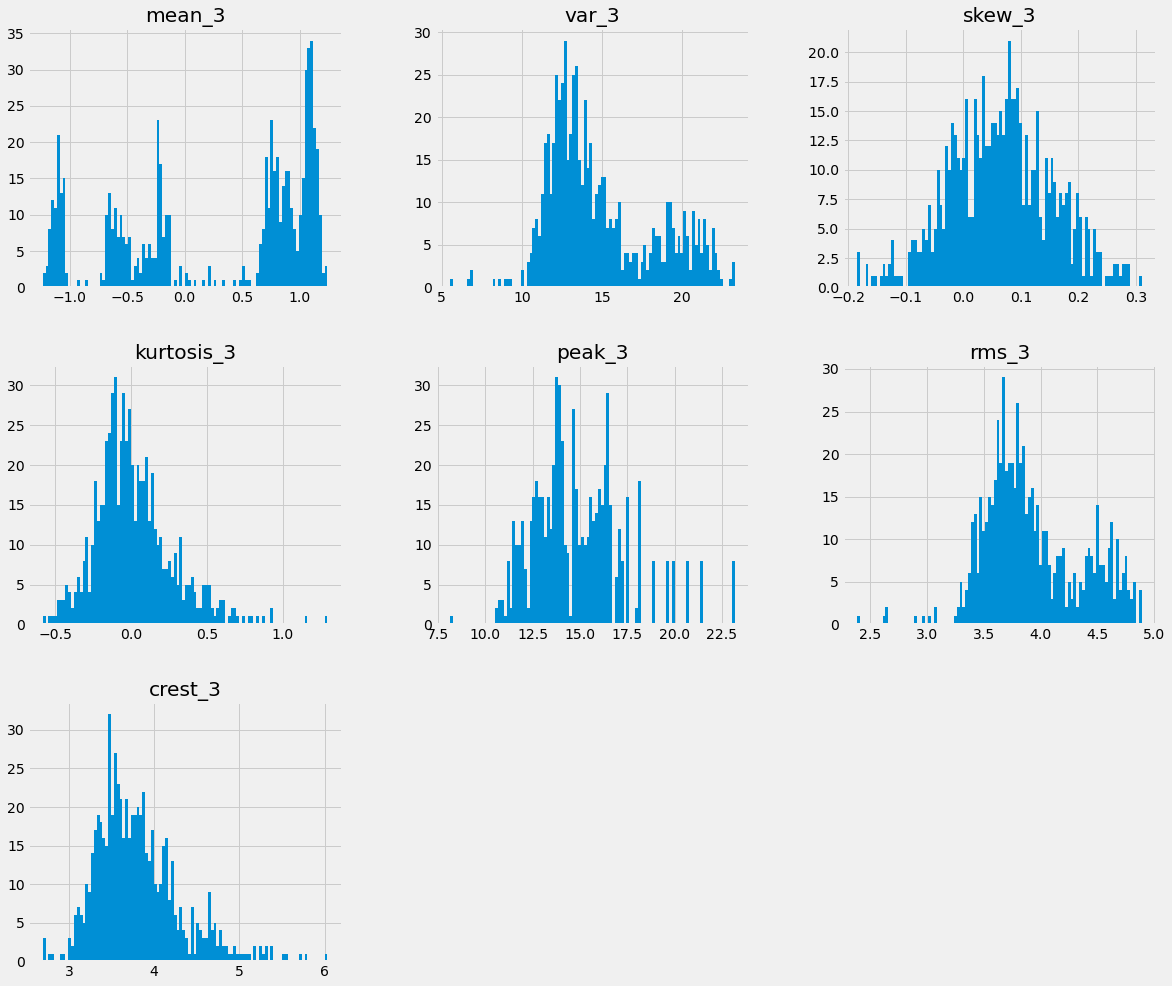

In [63]:
plt.style.use('fivethirtyeight')
data_vib_RR_RH = data_vib2.iloc[:,26:33]
data_vib_RR_RH = data_vib_RR_RH.dropna()
print(len(data_vib_RR_RH))
print(data_vib_RR_RH.head())
data_vib_RR_RH.plot(figsize=(20,15))
data_vib_RR_RH.hist(bins=100, figsize=(18,16))
plt.show()

652
                           mean_4      var_4    skew_4  kurtosis_4     peak_4  \
DateTime                                                                        
2020-02-25 16:43:31.105 -0.019104  14.359297 -0.219569    0.632059  16.123936   
2020-02-25 16:43:32.355 -0.069442  14.029472 -0.208910    0.710439  16.123936   
2020-02-25 16:43:33.605 -0.002257  12.635500 -0.202033    0.908413  16.123936   
2020-02-25 16:43:34.855 -0.060725  12.053453 -0.197633    1.152888  16.123936   
2020-02-25 16:43:36.105  0.000869  11.230821 -0.283834    1.431918  16.123936   

                            rms_4   crest_4  
DateTime                                     
2020-02-25 16:43:31.105  3.788467  4.256058  
2020-02-25 16:43:32.355  3.745301  4.305111  
2020-02-25 16:43:33.605  3.553757  4.537152  
2020-02-25 16:43:34.855  3.471471  4.644698  
2020-02-25 16:43:36.105  3.350404  4.812535  


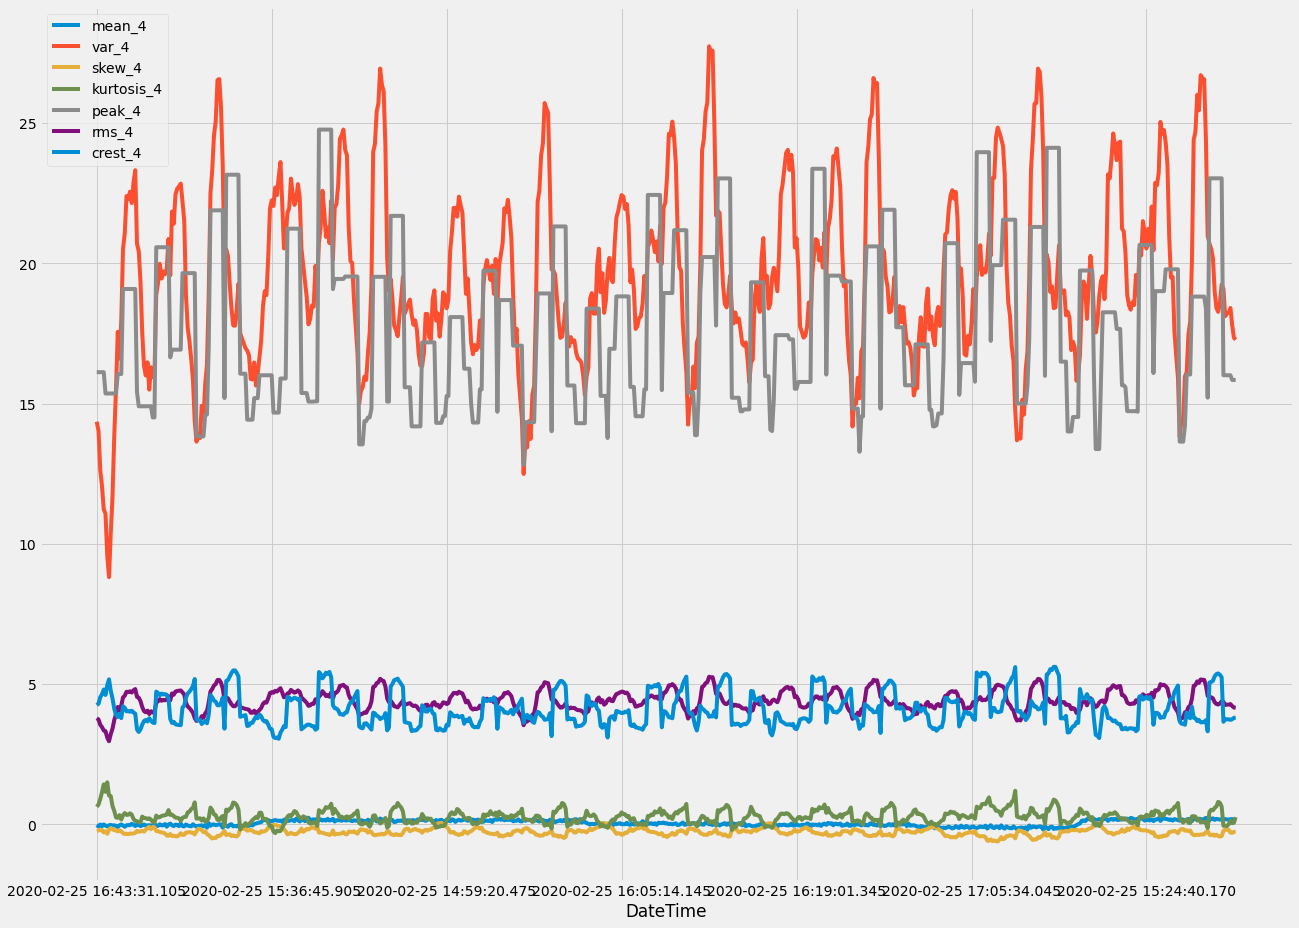

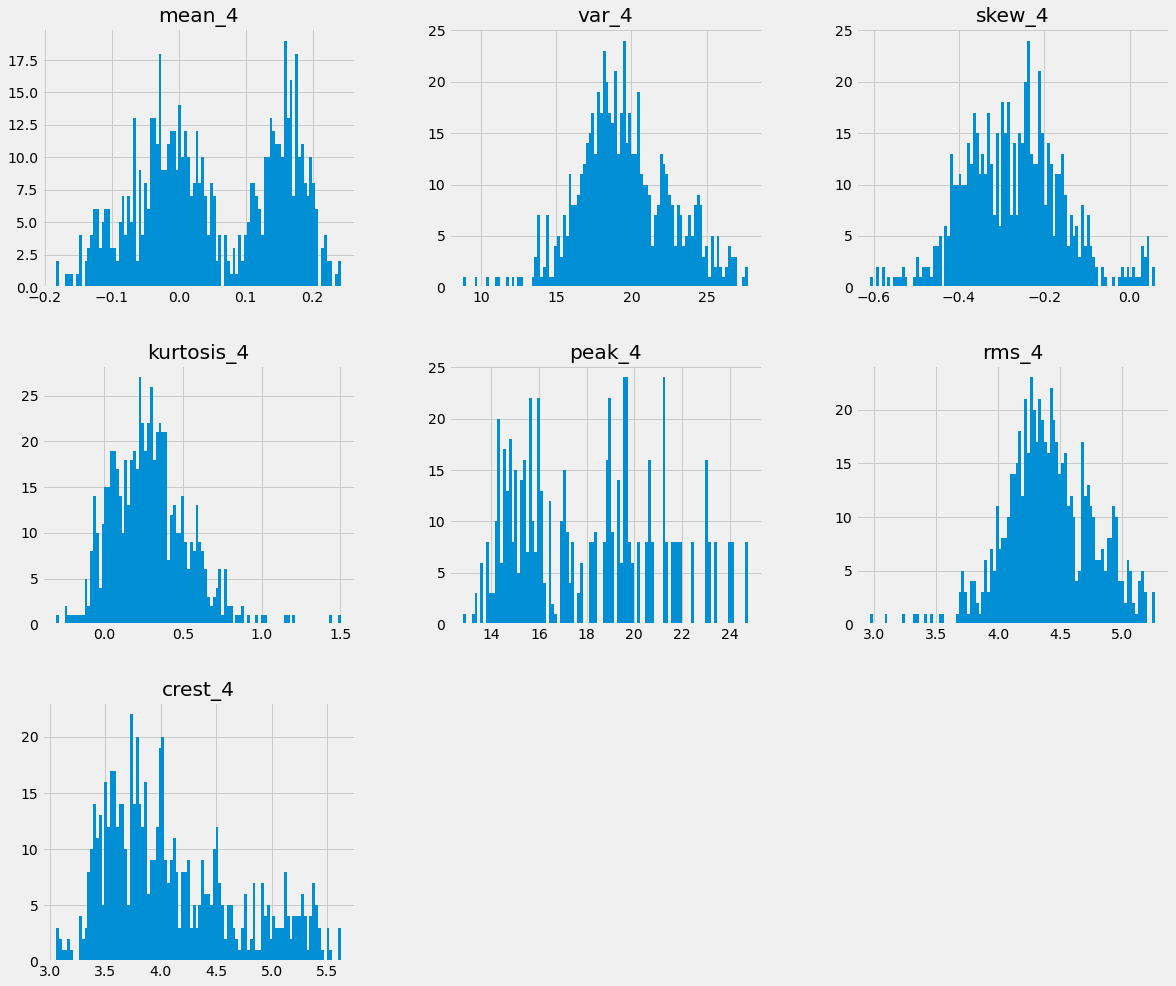

In [64]:
plt.style.use('fivethirtyeight')
data_vib_Cabin = data_vib2.iloc[:,33:40]
data_vib_Cabin = data_vib_Cabin.dropna()
print(len(data_vib_Cabin))
print(data_vib_Cabin.head())
data_vib_Cabin.plot(figsize=(20,15))
data_vib_Cabin.hist(bins=100, figsize=(18,16))
plt.show()

# Import and read test (subset of Feb - normal vehicle) set

In [65]:
data = pd.read_csv("Input_Data_Files/RoughDataTest_Feb.csv", index_col=0)
data

FR_LH [m/s2]  FR_RH [m/s2]  RR_LH [m/s2]  \
DateTime                                                            
2020-02-25 15:02:23.430     -8.365533     -6.024143     -6.996150   
2020-02-25 15:02:23.435    -11.155451     -2.192894     -5.360354   
2020-02-25 15:02:23.440     -9.144586     -6.445586     -8.112810   
2020-02-25 15:02:23.445     -1.243389     -7.474725     -3.406589   
2020-02-25 15:02:23.450     -4.011792     -6.015308     -7.426538   
...                               ...           ...           ...   
2020-02-25 17:10:11.745      5.369437     -5.901467      3.192574   
2020-02-25 17:10:11.750     -2.640386     -7.980957      4.946055   
2020-02-25 17:10:11.755     -7.514707     -5.436108      2.104472   
2020-02-25 17:10:11.760     -7.831190     -0.595201      4.600119   
2020-02-25 17:10:11.765     -4.082514      0.243120     -0.075564   

                         RR_RH [m/s2]  Cabin [m/s2]  
DateTime                                             
2020-02-25 15:02:23.430     -3.959084      0.104379  
2020-02-25 15:02:23.435     -4.869436     -3.251968  
2020-02-25 15:02:23.440     -4.643099    -11.036530  
2020-02-25 15:02:23.445     -1.470600    -13.574854  
2020-02-25 15:02:23.450     -4.181741    -13.558696  
...                               ...           ...  
2020-02-25 17:10:11.745      0.037849      1.845282  
2020-02-25 17:10:11.750     -1.059476      1.054901  
2020-02-25 17:10:11.755     -2.563446     -1.928436  
2020-02-25 17:10:11.760      0.272533     -3.949953  
2020-02-25 17:10:11.765     -3.236274     -7.697108  

[187517 rows x 5 columns]

In [12]:
data.describe()

FR_LH [m/s2]   FR_RH [m/s2]   RR_LH [m/s2]   RR_RH [m/s2]  \
count  187517.000000  187517.000000  187517.000000  187517.000000   
mean        0.752771       0.295051      -0.041388       0.136587   
std         5.164089       5.002301       4.178139       3.954201   
min       -31.671457     -25.889437     -20.499136     -18.982910   
25%        -2.498753      -2.925361      -2.882398      -2.494624   
50%         1.002922       0.454955      -0.038456       0.106208   
75%         4.277220       3.697858       2.788680       2.740159   
max        22.476803      22.801096      18.606867      22.795959   

        Cabin [m/s2]  
count  187517.000000  
mean        0.053035  
std         4.454828  
min       -24.831045  
25%        -2.752378  
50%         0.235195  
75%         3.102170  
max        18.714262

array([<AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>, <AxesSubplot:xlabel='DateTime'>,
       <AxesSubplot:xlabel='DateTime'>], dtype=object)

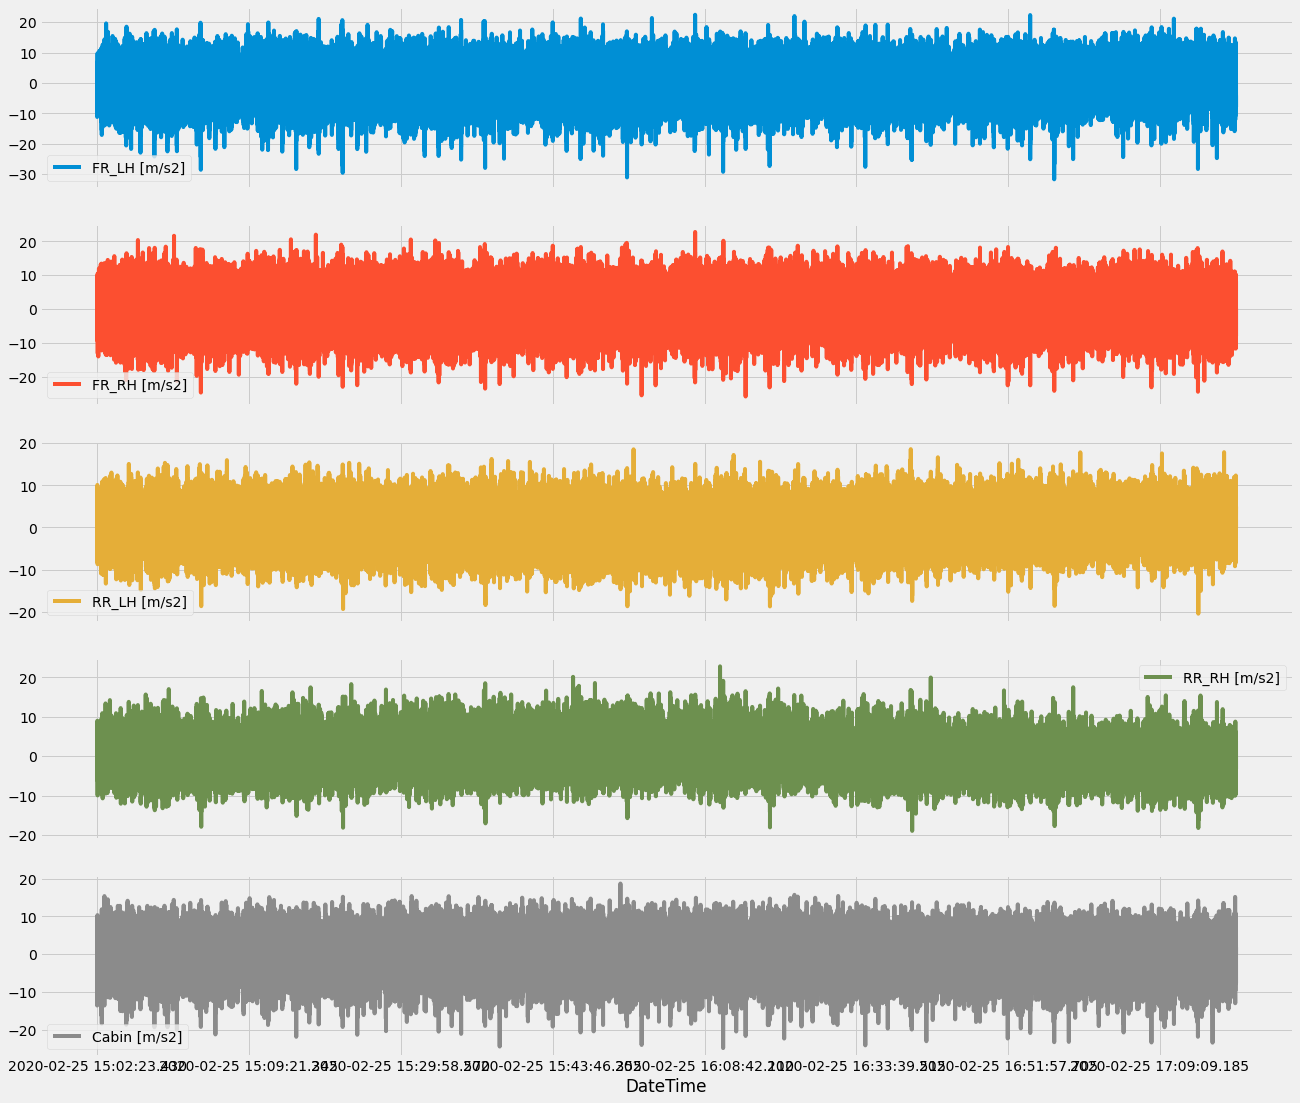

In [66]:
plt.style.use('fivethirtyeight')
data.plot(figsize=(20,18), subplots=True)

In [14]:
data_test_new = data.reset_index()
data_test1 = data_test_new.iloc[:,1:6]
data_test1

FR_LH [m/s2]  FR_RH [m/s2]  RR_LH [m/s2]  RR_RH [m/s2]  Cabin [m/s2]
0          -8.365533     -6.024143     -6.996150     -3.959084      0.104379
1         -11.155451     -2.192894     -5.360354     -4.869436     -3.251968
2          -9.144586     -6.445586     -8.112810     -4.643099    -11.036530
3          -1.243389     -7.474725     -3.406589     -1.470600    -13.574854
4          -4.011792     -6.015308     -7.426538     -4.181741    -13.558696
...              ...           ...           ...           ...           ...
187512      5.369437     -5.901467      3.192574      0.037849      1.845282
187513     -2.640386     -7.980957      4.946055     -1.059476      1.054901
187514     -7.514707     -5.436108      2.104472     -2.563446     -1.928436
187515     -7.831190     -0.595201      4.600119      0.272533     -3.949953
187516     -4.082514      0.243120     -0.075564     -3.236274     -7.697108

[187517 rows x 5 columns]

# Feature extraction (7 features for each sensor) of test set (total 35 features)

In [15]:
data_test1_new = time_domain_features(data_test1,2000,250)
data_test1_new

FR_LH [m/s2]  FR_RH [m/s2]  RR_LH [m/s2]  RR_RH [m/s2]  Cabin [m/s2]  \
0          -8.365533     -6.024143     -6.996150     -3.959084      0.104379   
1         -11.155451     -2.192894     -5.360354     -4.869436     -3.251968   
2          -9.144586     -6.445586     -8.112810     -4.643099    -11.036530   
3          -1.243389     -7.474725     -3.406589     -1.470600    -13.574854   
4          -4.011792     -6.015308     -7.426538     -4.181741    -13.558696   
...              ...           ...           ...           ...           ...   
187512      5.369437     -5.901467      3.192574      0.037849      1.845282   
187513     -2.640386     -7.980957      4.946055     -1.059476      1.054901   
187514     -7.514707     -5.436108      2.104472     -2.563446     -1.928436   
187515     -7.831190     -0.595201      4.600119      0.272533     -3.949953   
187516     -4.082514      0.243120     -0.075564     -3.236274     -7.697108   

        mean_0  var_0  skew_0  kurtosis_0  peak_0  ...  peak_3  rms_3  \
0          NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
1          NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
2          NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
3          NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
4          NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
...        ...    ...     ...         ...     ...  ...     ...    ...   
187512     NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
187513     NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
187514     NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
187515     NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   
187516     NaN    NaN     NaN         NaN     NaN  ...     NaN    NaN   

        crest_3  mean_4  var_4  skew_4  kurtosis_4  peak_4  rms_4  crest_4  
0           NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
1           NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
2           NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
3           NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
4           NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
...         ...     ...    ...     ...         ...     ...    ...      ...  
187512      NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
187513      NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
187514      NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
187515      NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  
187516      NaN     NaN    NaN     NaN         NaN     NaN    NaN      NaN  

[187517 rows x 40 columns]

# Considering extracted features for each sensor value of test 1 set (7 features at a time)

743
                     DateTime    mean_0      var_0    skew_0  kurtosis_0  \
1999  2020-02-25 15:02:33.425  0.343062  21.554373 -0.165787    0.327917   
2249  2020-02-25 15:02:34.675  0.373264  22.359879 -0.182461    0.234800   
2499  2020-02-25 15:02:35.925  0.422745  23.844844 -0.166243    0.054911   
2749  2020-02-25 15:02:37.175  0.355933  23.424869 -0.125019    0.130346   
2999  2020-02-25 15:02:38.425  0.412974  22.585305 -0.052842    0.027480   

         peak_0     rms_0   crest_0  
1999  19.635387  4.654169  4.218882  
2249  19.635387  4.742154  4.140605  
2499  19.635387  4.900167  4.007085  
2749  19.635387  4.851788  4.047042  
2999  19.635387  4.769126  4.117188  


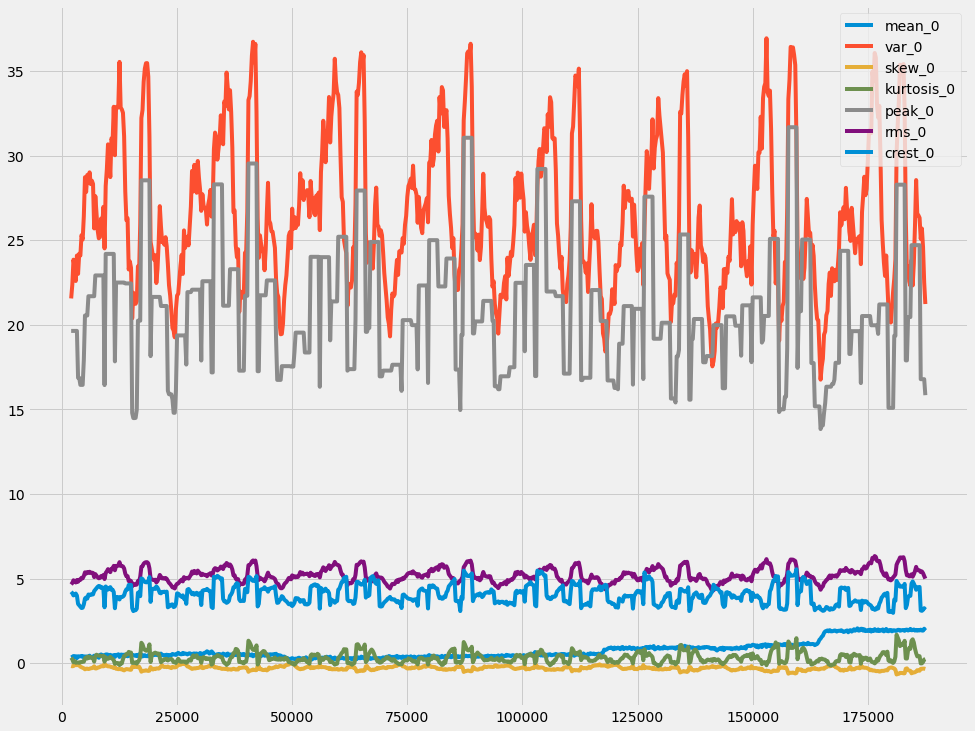

In [67]:
plt.style.use('fivethirtyeight')
data_new_FR_LH = data_test1_new.iloc[:,5:12]
data_new_FR_LH = pd.concat([data_test_new.loc[:,'DateTime'], data_new_FR_LH], axis=1 )
data_new_FR_LH
data_new_FR_LH = data_new_FR_LH.dropna()
print(len(data_new_FR_LH))
print(data_new_FR_LH.head())
data_new_FR_LH.plot(figsize=(15,12))
plt.show()

743
                     DateTime    mean_1      var_1    skew_1  kurtosis_1  \
1999  2020-02-25 15:02:33.425  0.170748  20.920179 -0.071563   -0.029732   
2249  2020-02-25 15:02:34.675  0.188278  21.382982 -0.087960   -0.095550   
2499  2020-02-25 15:02:35.925  0.227874  21.921075 -0.041102   -0.098454   
2749  2020-02-25 15:02:37.175  0.191612  21.193903 -0.041988   -0.059496   
2999  2020-02-25 15:02:38.425  0.251003  20.722670 -0.053224   -0.000349   

         peak_1     rms_1   crest_1  
1999  14.533214  4.575901  3.176033  
2249  14.533214  4.626850  3.141060  
2499  14.533214  4.686368  3.101168  
2749  14.533214  4.606519  3.154923  
2999  15.647472  4.557994  3.432973  


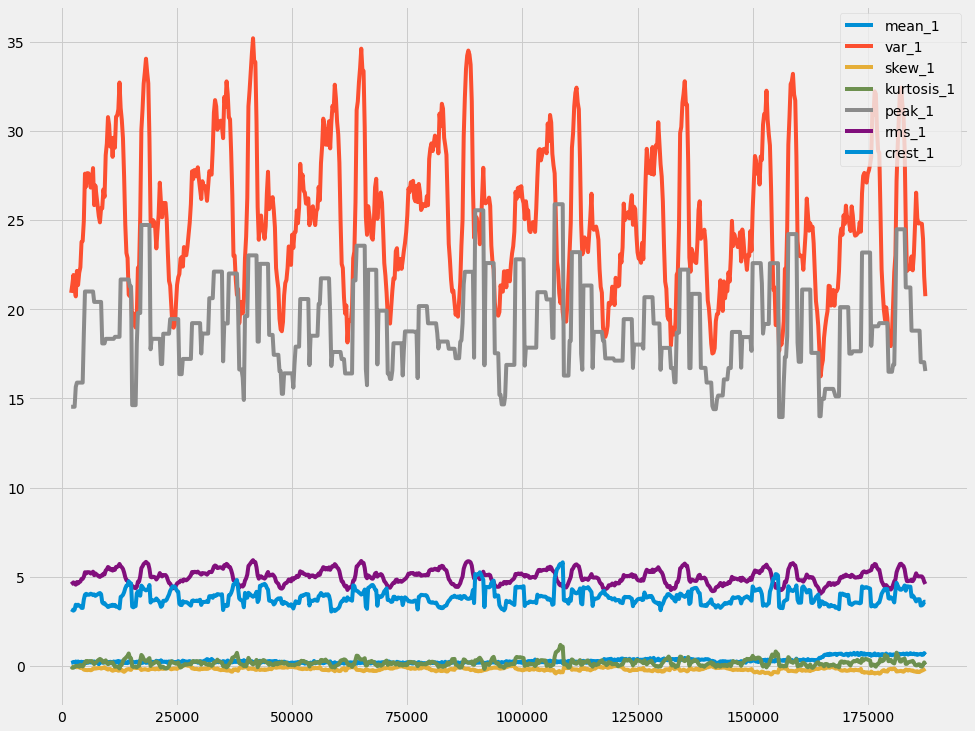

In [68]:
plt.style.use('fivethirtyeight')
data_new_FR_RH = data_test1_new.iloc[:,12:19]
data_new_FR_RH = pd.concat([data_test_new.loc[:,'DateTime'], data_new_FR_RH], axis=1 )
data_new_FR_RH = data_new_FR_RH.dropna()
print(len(data_new_FR_RH))
print(data_new_FR_RH.head())
data_new_FR_RH.plot(figsize=(15,12))
plt.show()

743
                     DateTime    mean_2      var_2    skew_2  kurtosis_2  \
1999  2020-02-25 15:02:33.425  0.123074  15.763985  0.059115   -0.157203   
2249  2020-02-25 15:02:34.675  0.146457  15.767193  0.078753   -0.157667   
2499  2020-02-25 15:02:35.925  0.119865  16.329798  0.109245   -0.199626   
2749  2020-02-25 15:02:37.175  0.156597  15.610731  0.111896   -0.164537   
2999  2020-02-25 15:02:38.425  0.118039  14.011447  0.150964   -0.039590   

         peak_2     rms_2   crest_2  
1999  13.348782  3.971303  3.361310  
2249  13.348782  3.972500  3.360297  
2499  13.348782  4.041782  3.302697  
2749  13.348782  3.953157  3.376740  
2999  13.348782  3.744112  3.565273  


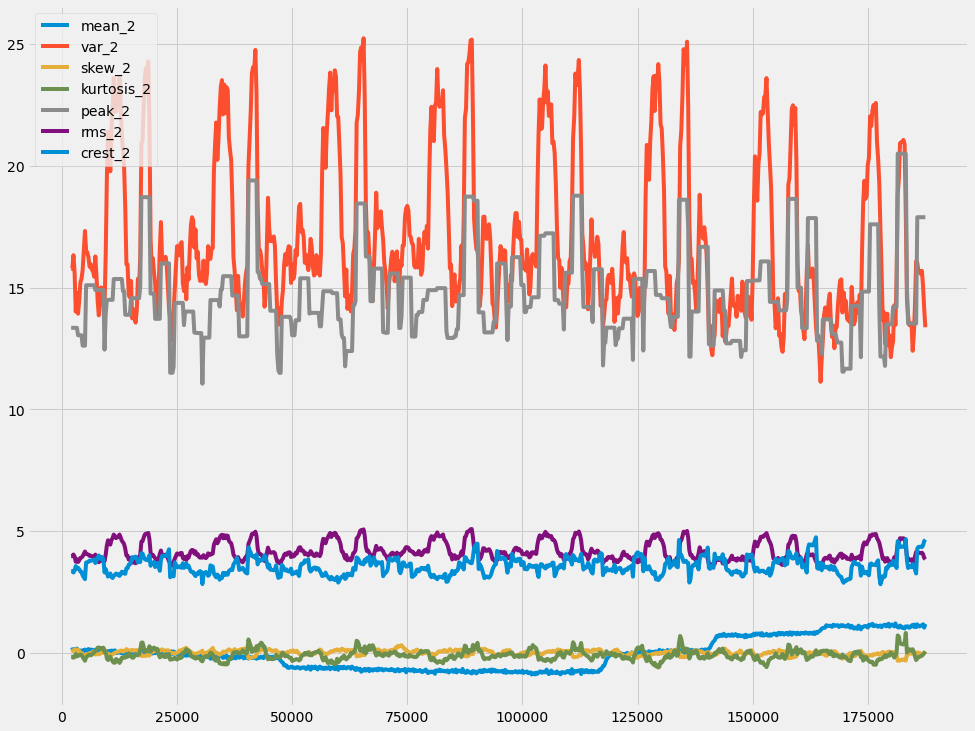

In [69]:
plt.style.use('fivethirtyeight')
data_new_RR_LH = data_test1_new.iloc[:,19:26]
data_new_RR_LH = pd.concat([data_test_new.loc[:,'DateTime'], data_new_RR_LH], axis=1 )
data_new_RR_LH = data_new_RR_LH.dropna()
print(len(data_new_RR_LH))
print(data_new_RR_LH.head())
data_new_RR_LH.plot(figsize=(15,12))
plt.show()

743
                     DateTime    mean_3      var_3    skew_3  kurtosis_3  \
1999  2020-02-25 15:02:33.425 -0.106746  12.735487  0.015754   -0.143950   
2249  2020-02-25 15:02:34.675 -0.108483  12.503227  0.060964   -0.021432   
2499  2020-02-25 15:02:35.925 -0.148232  13.223204  0.104096   -0.143732   
2749  2020-02-25 15:02:37.175 -0.113617  12.539532  0.077126   -0.071717   
2999  2020-02-25 15:02:38.425 -0.140681  11.558226  0.146184    0.025830   

         peak_3     rms_3   crest_3  
1999  13.387111  3.569386  3.750536  
2249  14.221837  3.536770  4.021137  
2499  14.221837  3.638484  3.908726  
2749  14.221837  3.542057  4.015135  
2999  14.221837  3.401799  4.180681  


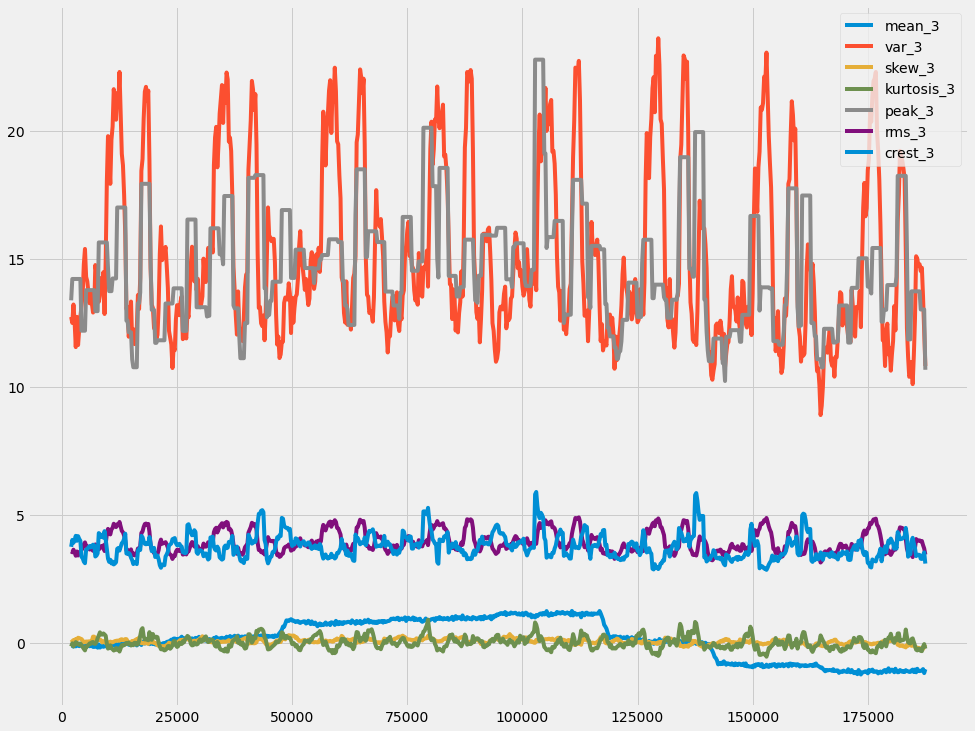

In [70]:
plt.style.use('fivethirtyeight')
data_new_RR_RH = data_test1_new.iloc[:,26:33]
data_new_RR_RH = pd.concat([data_test_new.loc[:,'DateTime'], data_new_RR_RH], axis=1 )
data_new_RR_RH = data_new_RR_RH.dropna()
print(len(data_new_RR_RH))
print(data_new_RR_RH.head())
data_new_RR_RH.plot(figsize=(15,12))
plt.show()

743
                     DateTime    mean_4      var_4    skew_4  kurtosis_4  \
1999  2020-02-25 15:02:33.425  0.101405  17.527500 -0.192829    0.331255   
2249  2020-02-25 15:02:34.675  0.132571  18.525524 -0.131304    0.212608   
2499  2020-02-25 15:02:35.925  0.159738  19.504611 -0.113954    0.101128   
2749  2020-02-25 15:02:37.175  0.117889  18.648873 -0.048839    0.076446   
2999  2020-02-25 15:02:38.425  0.159750  17.876433  0.057227   -0.038305   

         peak_4     rms_4   crest_4  
1999  18.355103  4.186767  4.384075  
2249  18.355103  4.305094  4.263578  
2499  18.355103  4.418187  4.154442  
2749  18.355103  4.318964  4.249886  
2999  15.397249  4.230014  3.640000  


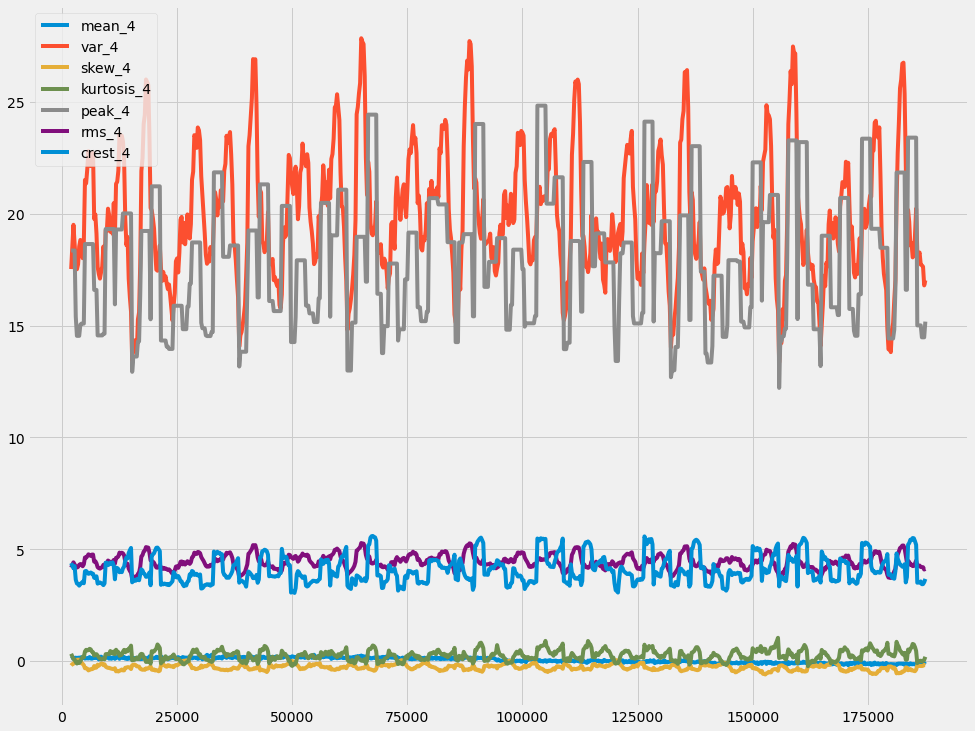

In [71]:
plt.style.use('fivethirtyeight')
data_new_Cabin = data_test1_new.iloc[:,33:40]
data_new_Cabin = pd.concat([data_test_new.loc[:,'DateTime'], data_new_Cabin], axis=1 )
data_new_Cabin = data_new_Cabin.dropna()
print(len(data_new_Cabin))
print(data_new_Cabin.head())
data_new_Cabin.plot(figsize=(15,12))
plt.show()

# Mahalanobis distance calculation function

In [23]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Mahalanobis distance calculation for test 1 set for FR_LH sensor comparing with mean and covariance values of train (reference) set

In [24]:
df_FR_LH = data_new_FR_LH[['mean_0', 'var_0', 'skew_0', 'kurtosis_0', 'peak_0', 'rms_0', 'crest_0']]
df_FR_LH['mahala'] = mahalanobis(x=df_FR_LH, data=data_vib_FR_LH[['mean_0', 'var_0', 'skew_0', 'kurtosis_0', 'peak_0', 'rms_0', 'crest_0']])
df_FR_LH = pd.concat([data_new_FR_LH['DateTime'], df_FR_LH], axis =1)
df_FR_LH_asc = df_FR_LH.sort_values(by=['mahala'], ascending=False)
df_FR_LH_asc

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


DateTime    mean_0      var_0    skew_0  kurtosis_0  \
176499  2020-02-25 17:09:16.680  2.014299  36.056497 -0.436121   -0.009285   
176749  2020-02-25 17:09:17.930  1.928292  35.783454 -0.466807    0.056707   
158249  2020-02-25 16:52:38.950  1.071113  36.417530 -0.566982    0.901066   
158499  2020-02-25 16:52:40.200  1.099223  36.342502 -0.566876    0.905696   
181249  2020-02-25 17:09:40.430  1.915891  30.116039 -0.666577    1.682639   
...                         ...       ...        ...       ...         ...   
98749   2020-02-25 16:08:35.855  0.441621  27.361633 -0.324207    0.494364   
40249   2020-02-25 15:11:32.665  0.415599  26.673461 -0.308322    0.458932   
110499  2020-02-25 16:10:29.510  0.561904  25.759591 -0.307481    0.445308   
89499   2020-02-25 15:45:53.940  0.448814  25.158509 -0.260664    0.209059   
21249   2020-02-25 15:05:04.715  0.455517  27.008091 -0.279103    0.342335   

           peak_0     rms_0   crest_0     mahala  
176499  19.968826  6.332130  3.153572  32.495657  
176749  19.968826  6.283619  3.177918  29.889925  
158249  31.671457  6.127528  5.168716  29.287671  
158499  31.671457  6.126387  5.169679  29.186564  
181249  28.276075  5.811335  4.865676  28.891665  
...           ...       ...       ...        ...  
98749   22.476803  5.248141  4.282813   0.396367  
40249   21.709347  5.180043  4.190959   0.388501  
110499  21.877831  5.105139  4.285452   0.311894  
89499   19.486673  5.034617  3.870538   0.274013  
21249   21.644045  5.215562  4.149897   0.175361  

[743 rows x 9 columns]

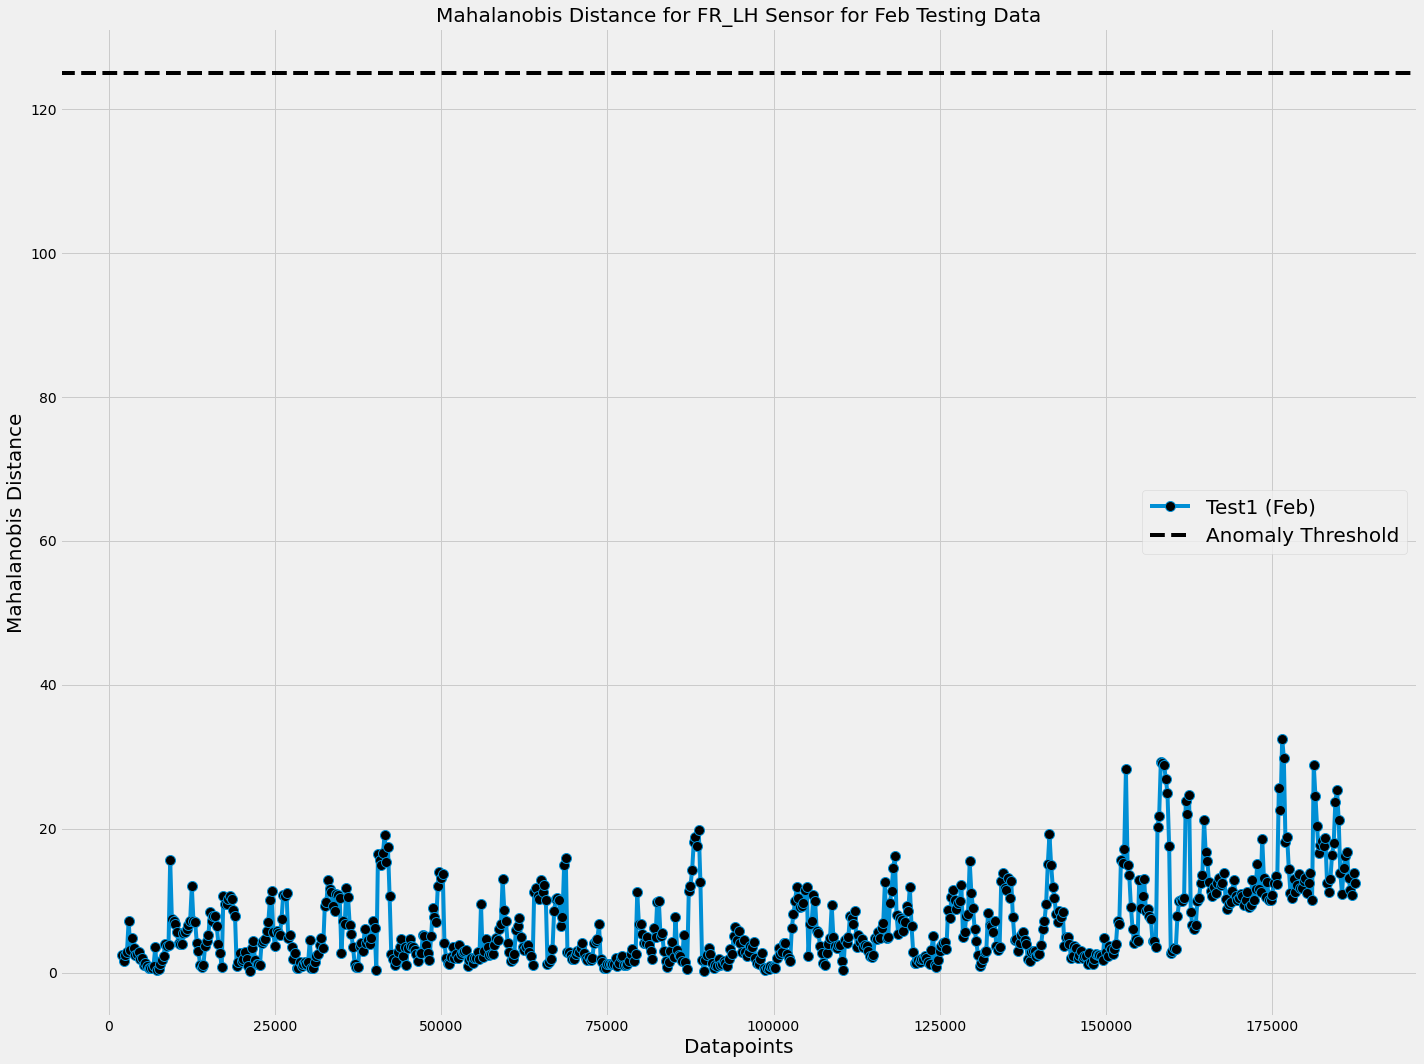

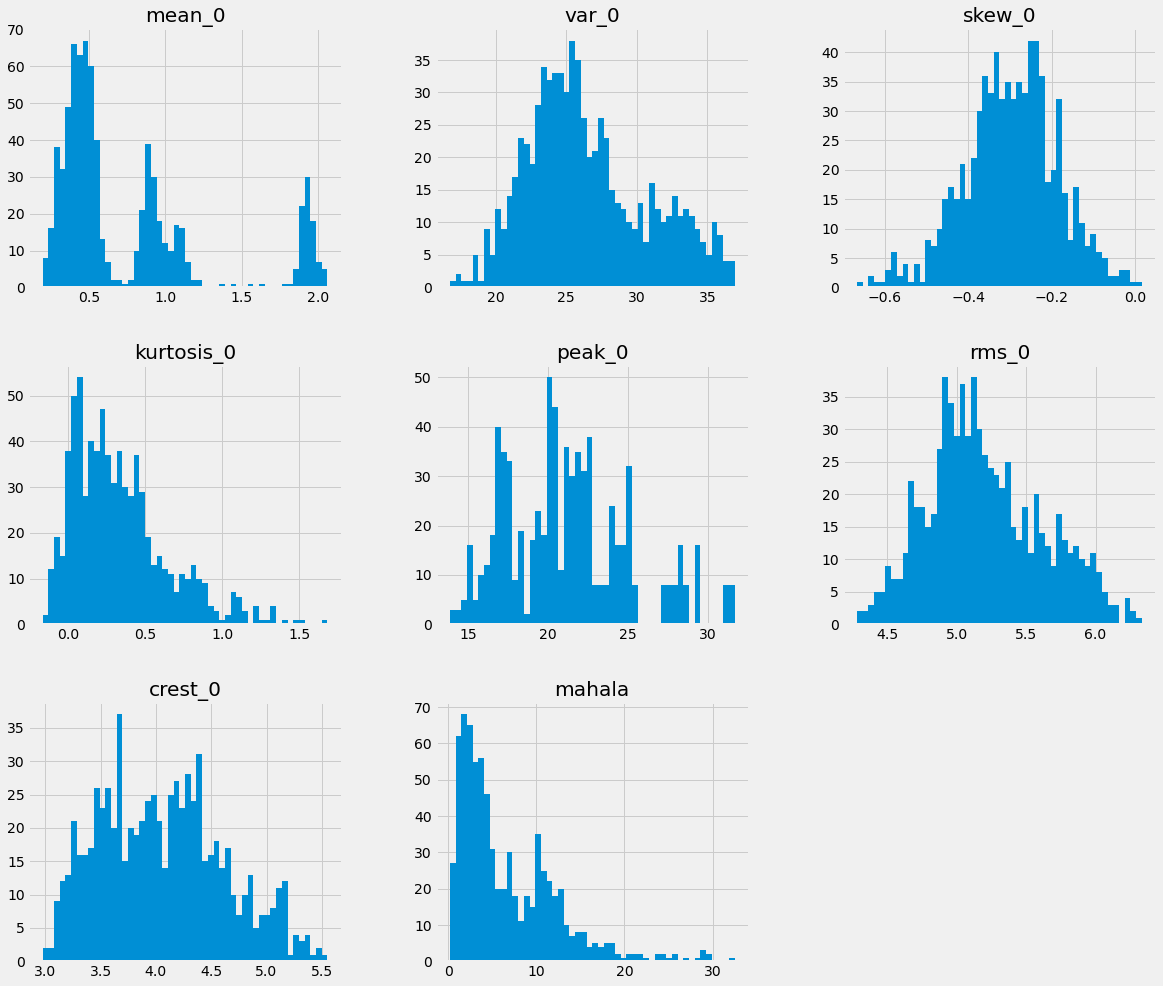

In [25]:
plt.style.use('fivethirtyeight')
ax = df_FR_LH['mahala'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('Mahalanobis Distance for FR_LH Sensor for Feb Testing Data', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(125, color='k', linestyle='--')
ax.legend(("Test1 (Feb)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

df_FR_LH.hist(bins=50, figsize=(18,16))
plt.show()

# Mahalanobis distance calculation for test set 1 for FR_RH sensor comparing with mean and covariance values of train (reference) set

In [26]:
df_FR_RH = data_new_FR_RH[['mean_1', 'var_1', 'skew_1', 'kurtosis_1', 'peak_1', 'rms_1', 'crest_1']]
df_FR_RH['mahala'] = mahalanobis(x=df_FR_RH, data=data_vib_FR_RH[['mean_1', 'var_1', 'skew_1', 'kurtosis_1', 'peak_1', 'rms_1', 'crest_1']])
df_FR_RH = pd.concat([data_new_FR_RH['DateTime'], df_FR_RH], axis =1)
df_FR_RH_asc = df_FR_RH.sort_values(by=['mahala'], ascending=False)
df_FR_RH_asc

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


DateTime    mean_1      var_1    skew_1  kurtosis_1  \
108749  2020-02-25 16:10:20.760  0.150859  19.837851 -0.353528    1.087124   
108249  2020-02-25 16:10:18.260  0.257933  20.344344 -0.365009    1.181915   
107999  2020-02-25 16:10:17.010  0.219332  20.893408 -0.280536    0.965955   
108499  2020-02-25 16:10:19.510  0.271529  21.051566 -0.337376    0.997486   
154999  2020-02-25 16:52:22.700  0.359522  19.109205 -0.346013    0.812198   
...                         ...       ...        ...       ...         ...   
115499  2020-02-25 16:10:54.510  0.278722  24.455831 -0.148697    0.125798   
115749  2020-02-25 16:10:55.760  0.256388  24.519379 -0.153104    0.097575   
145499  2020-02-25 16:50:40.095  0.197714  24.955972 -0.204081    0.152949   
19749   2020-02-25 15:04:57.215  0.234139  25.000500 -0.155615    0.122581   
19499   2020-02-25 15:04:55.965  0.201877  24.663459 -0.170262    0.115632   

           peak_1     rms_1   crest_1     mahala  
108749  25.889437  4.455411  5.810785  81.894774  
108249  25.889437  4.516714  5.731919  70.966399  
107999  25.889437  4.575048  5.658834  51.250544  
108499  25.889437  4.595081  5.634163  47.758473  
154999  22.583643  4.385078  5.150112  45.109696  
...           ...       ...       ...        ...  
115499  18.731907  4.951898  3.782774   0.575328  
115749  18.731907  4.957101  3.778802   0.566479  
145499  18.728859  4.998258  3.747077   0.563710  
19749   18.342018  5.004280  3.665266   0.531216  
19499   18.342018  4.969093  3.691221   0.458366  

[743 rows x 9 columns]

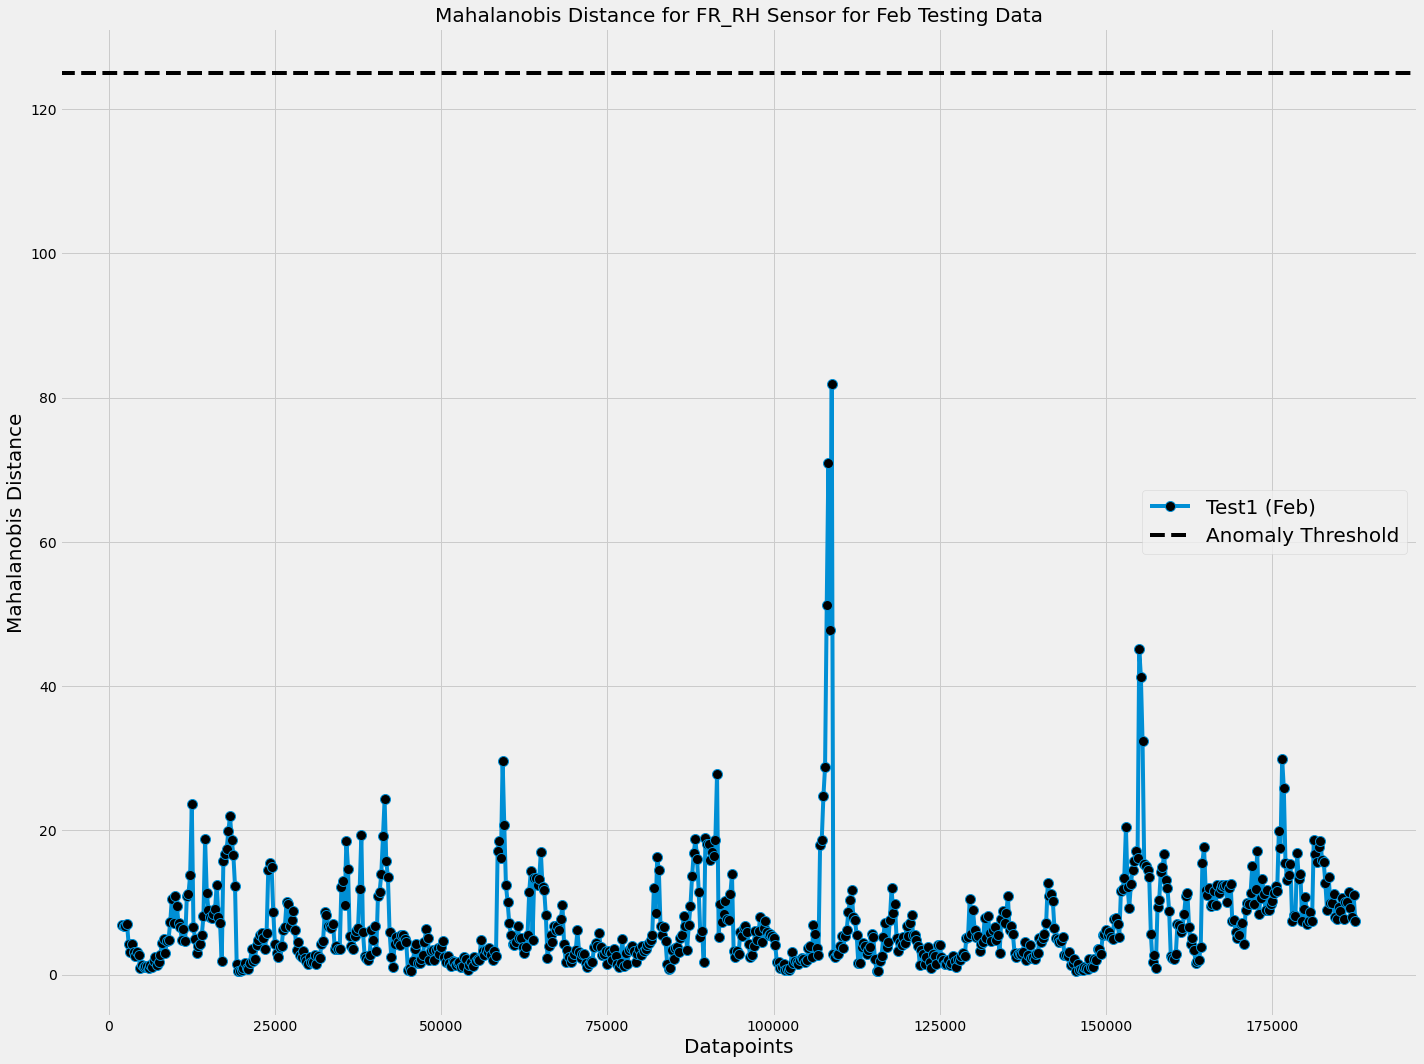

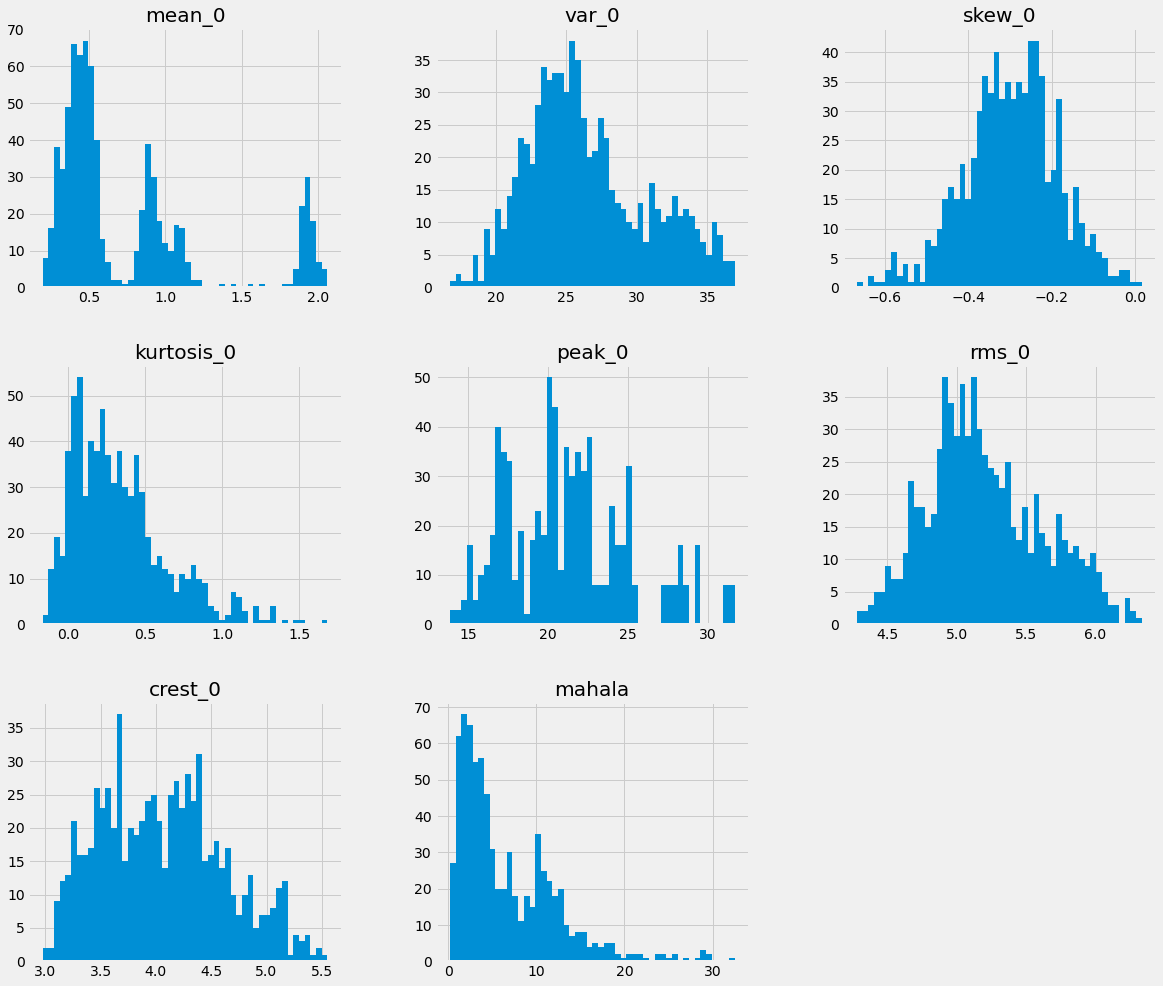

In [27]:
plt.style.use('fivethirtyeight')
ax = df_FR_RH['mahala'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('Mahalanobis Distance for FR_RH Sensor for Feb Testing Data', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(125, color='k', linestyle='--')
ax.legend(("Test1 (Feb)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

df_FR_LH.hist(bins=50, figsize=(18,16))
plt.show()

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Mahalanobis distance')

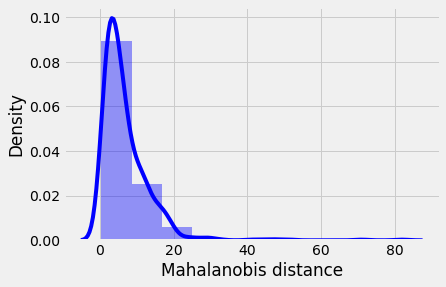

In [28]:
plt.figure()
sns.distplot(df_FR_RH['mahala'],
             bins = 10, 
             kde= True, 
            color = 'blue');
plt.xlabel('Mahalanobis distance')

# Mahalanobis distance calculation for test set 1 for RR_LH sensor comparing with mean and covariance values of train (reference) set

In [29]:
df_RR_LH = data_new_RR_LH[['mean_2', 'var_2', 'skew_2', 'kurtosis_2', 'peak_2', 'rms_2', 'crest_2']]
df_RR_LH['mahala'] = mahalanobis(x=df_RR_LH, data=data_vib_RR_LH[['mean_2', 'var_2', 'skew_2', 'kurtosis_2', 'peak_2', 'rms_2', 'crest_2']])
df_RR_LH = pd.concat([data_new_RR_LH['DateTime'], df_RR_LH], axis =1)
df_RR_LH_asc = df_RR_LH.sort_values(by=['mahala'], ascending=False)
df_RR_LH_asc

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


DateTime    mean_2      var_2    skew_2  kurtosis_2  \
183249  2020-02-25 17:09:50.430  1.090550  18.074437 -0.314166    0.819191   
181499  2020-02-25 17:09:41.680  1.057315  18.846715 -0.321766    0.717650   
181749  2020-02-25 17:09:42.930  1.040251  19.466095 -0.310823    0.674543   
187499  2020-02-25 17:10:11.680  1.186016  13.370840  0.072174    0.053172   
181999  2020-02-25 17:09:44.180  1.122625  20.923468 -0.316156    0.397859   
...                         ...       ...        ...       ...         ...   
28249   2020-02-25 15:09:37.590 -0.064063  17.888748  0.002047   -0.145807   
48749   2020-02-25 15:29:52.315 -0.512903  15.931337  0.001826   -0.106266   
49249   2020-02-25 15:29:54.815 -0.615182  16.699104  0.049689   -0.168026   
53749   2020-02-25 15:30:17.315 -0.615147  16.094833  0.035178   -0.092891   
48999   2020-02-25 15:29:53.565 -0.603951  16.479149  0.045711   -0.119455   

           peak_2     rms_2   crest_2     mahala  
183249  20.499136  4.388018  4.671617  33.141303  
181499  20.499136  4.467125  4.588888  28.469992  
181749  20.499136  4.531941  4.523258  25.968575  
187499  17.890100  3.843278  4.654906  23.679056  
181999  20.499136  4.708853  4.353319  22.921517  
...           ...       ...       ...        ...  
28249   14.016309  4.228937  3.314381   1.165288  
48749   13.801030  4.023238  3.430329   1.119958  
49249   13.801030  4.131489  3.340449   1.065853  
53749   13.931268  4.057732  3.433264   1.038637  
48999   13.801030  4.103129  3.363538   0.982515  

[743 rows x 9 columns]

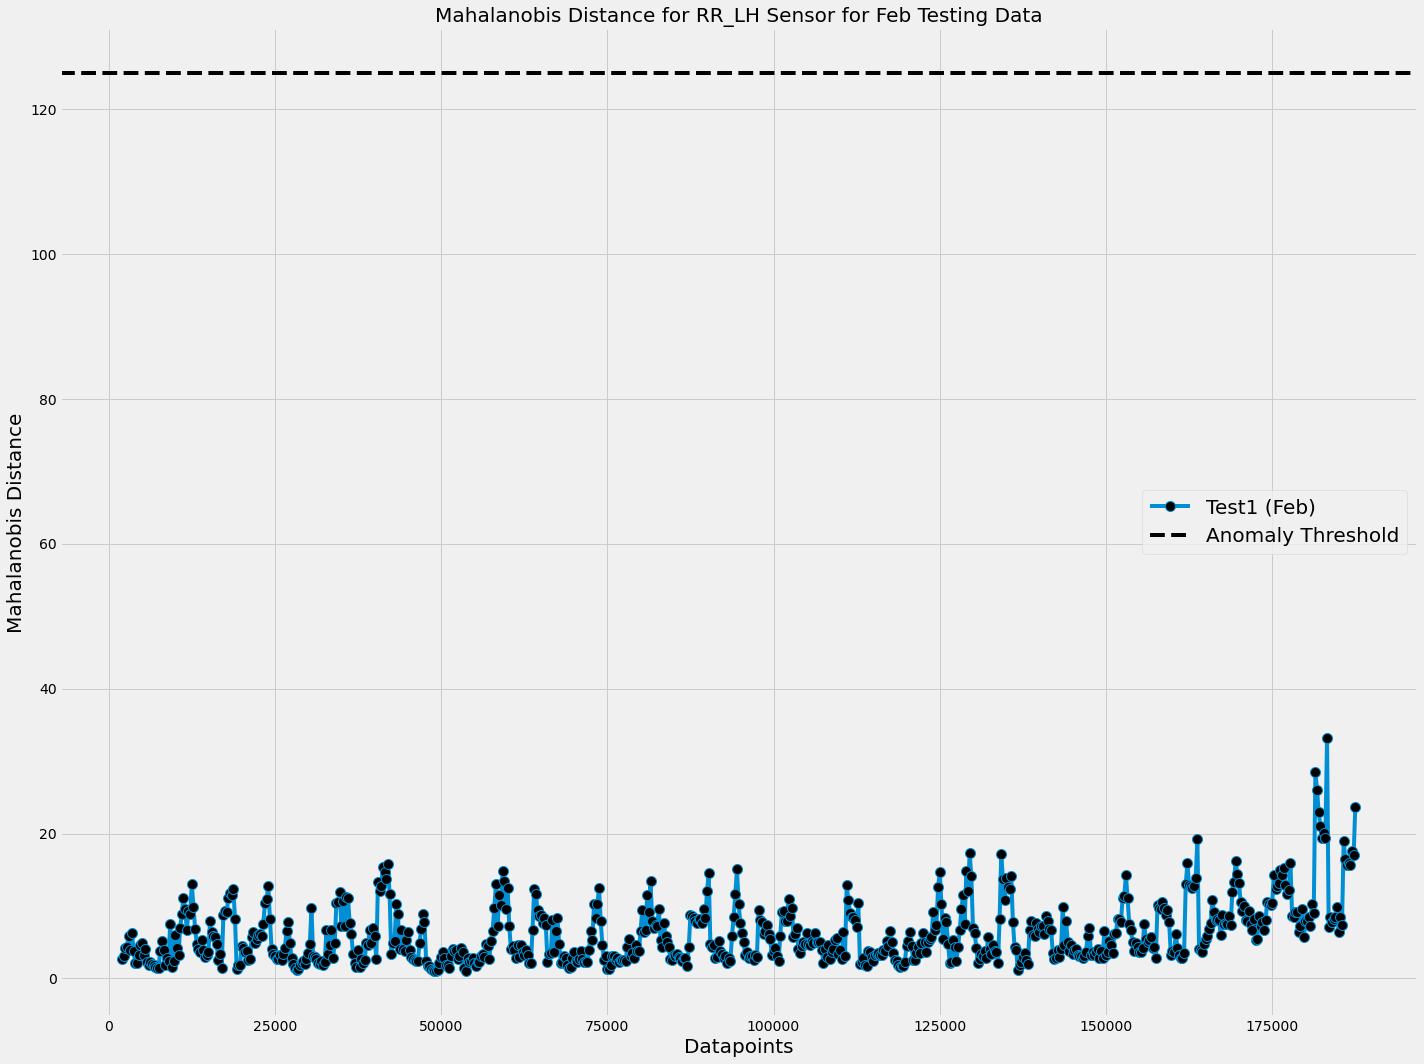

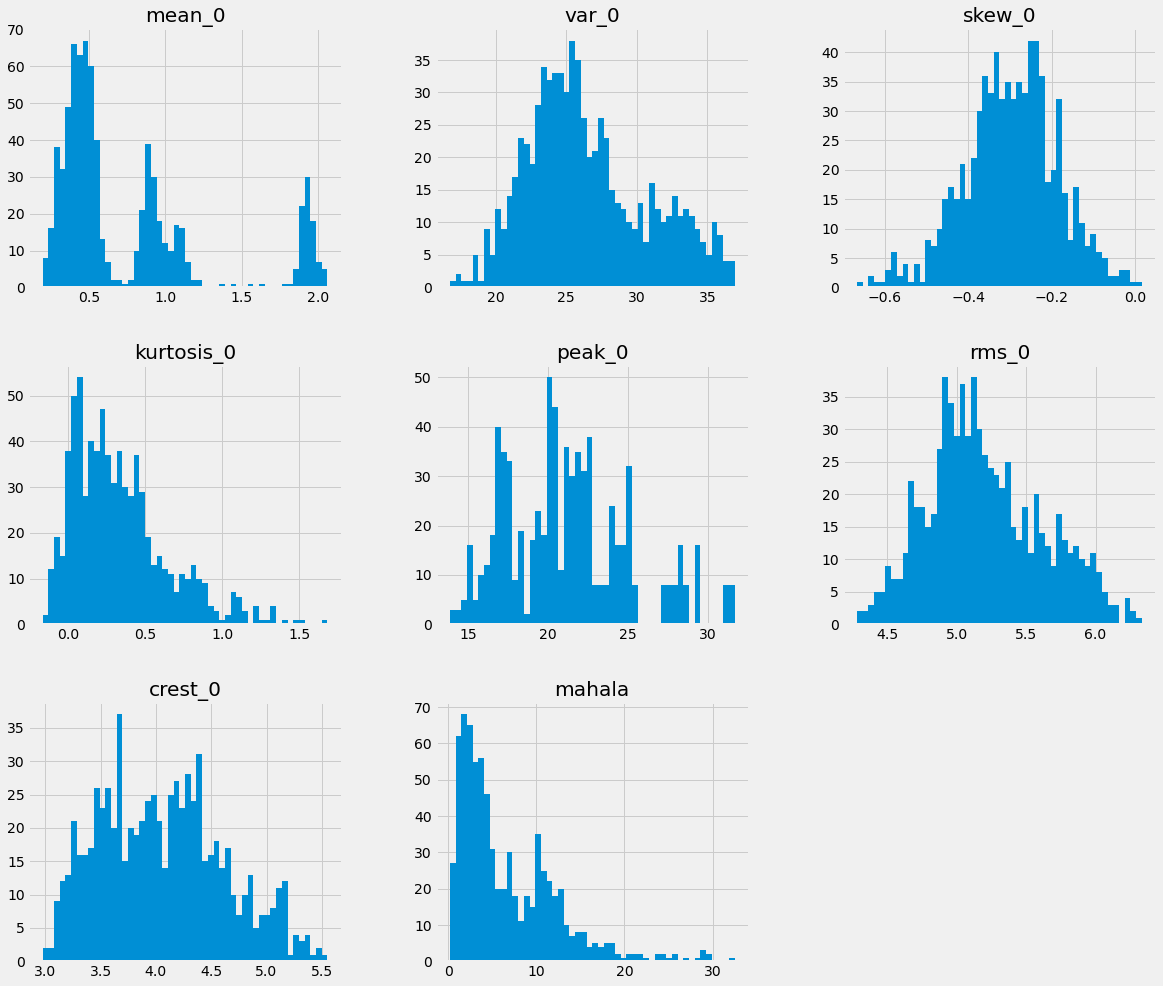

In [30]:
plt.style.use('fivethirtyeight')
ax = df_RR_LH['mahala'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('Mahalanobis Distance for RR_LH Sensor for Feb Testing Data', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(125, color='k', linestyle='--')
ax.legend(("Test1 (Feb)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

df_FR_LH.hist(bins=50, figsize=(18,16))
plt.show()

# Mahalanobis distance calculation for test set 1 for RR_RH sensor comparing with mean and covariance values of train (reference) set

In [31]:
df_RR_RH = data_new_RR_RH[['mean_3', 'var_3', 'skew_3', 'kurtosis_3', 'peak_3', 'rms_3', 'crest_3']]
df_RR_RH['mahala'] = mahalanobis(x=df_RR_RH, data=data_vib_RR_RH[['mean_3', 'var_3', 'skew_3', 'kurtosis_3', 'peak_3', 'rms_3', 'crest_3']])
df_RR_RH = pd.concat([data_new_RR_RH['DateTime'], df_RR_RH], axis =1)
df_RR_RH_asc = df_RR_RH.sort_values(by=['mahala'], ascending=False)
df_RR_RH_asc

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


DateTime    mean_3      var_3    skew_3  kurtosis_3  \
137749  2020-02-25 16:34:43.260 -0.044139  11.638534  0.043383    0.757589   
137499  2020-02-25 16:34:42.010  0.008918  11.962408  0.071983    0.813598   
137999  2020-02-25 16:34:44.510 -0.002957  12.939394 -0.003102    0.479566   
103749  2020-02-25 16:09:55.760  1.131487  20.649836  0.069315    0.064394   
160999  2020-02-25 16:52:52.700 -0.885528  11.223688 -0.021377    0.420562   
...                         ...       ...        ...       ...         ...   
53499   2020-02-25 15:30:16.065  0.861261  13.202421  0.113589    0.080849   
69749   2020-02-25 15:32:32.390  0.787446  15.093270  0.044733   -0.025344   
93249   2020-02-25 15:46:12.690  0.915842  14.189229  0.096859    0.098316   
52749   2020-02-25 15:30:12.315  0.835170  13.793641  0.111800    0.084860   
52999   2020-02-25 15:30:13.565  0.752101  14.222106  0.055513    0.068010   

           peak_3     rms_3   crest_3     mahala  
137749  19.964132  3.410962  5.852933  63.283618  
137499  19.964132  3.457818  5.773621  51.144471  
137999  19.964132  3.596239  5.551392  34.393506  
103749  22.795959  4.681856  4.869001  28.942880  
160999  17.484869  3.464424  5.046977  28.530994  
...           ...       ...       ...        ...  
53499   14.648195  3.733308  3.923650   1.072091  
69749   15.664556  3.963054  3.952648   0.999224  
93249   15.914968  3.875681  4.106367   0.934981  
52749   14.648195  3.805818  3.848895   0.878516  
52999   14.648195  3.844561  3.810108   0.832250  

[743 rows x 9 columns]

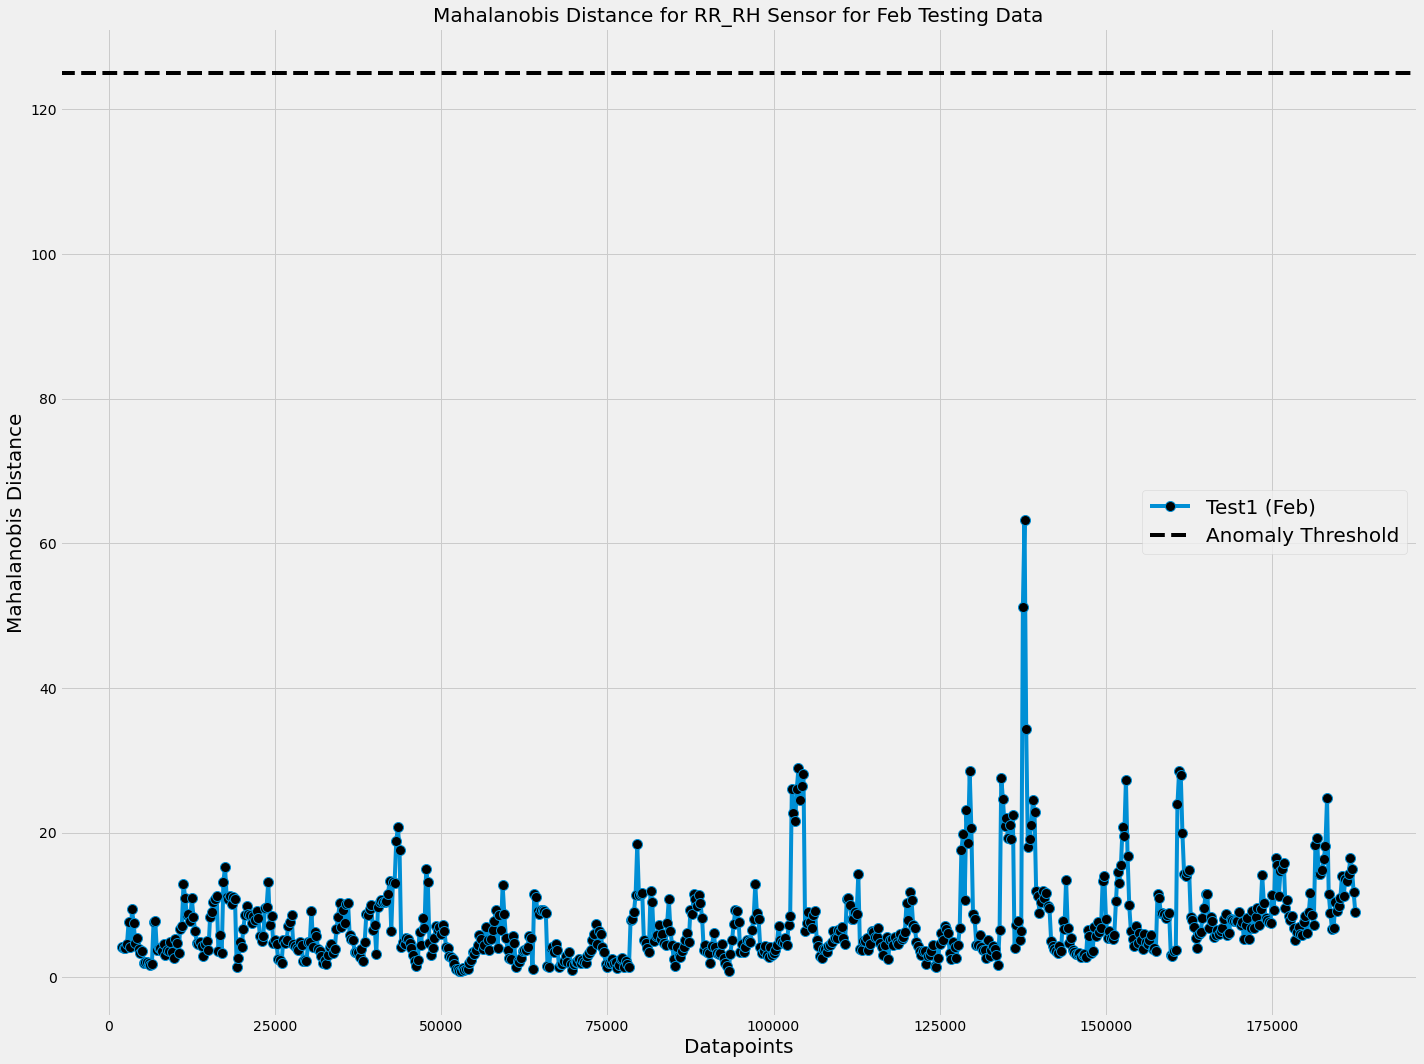

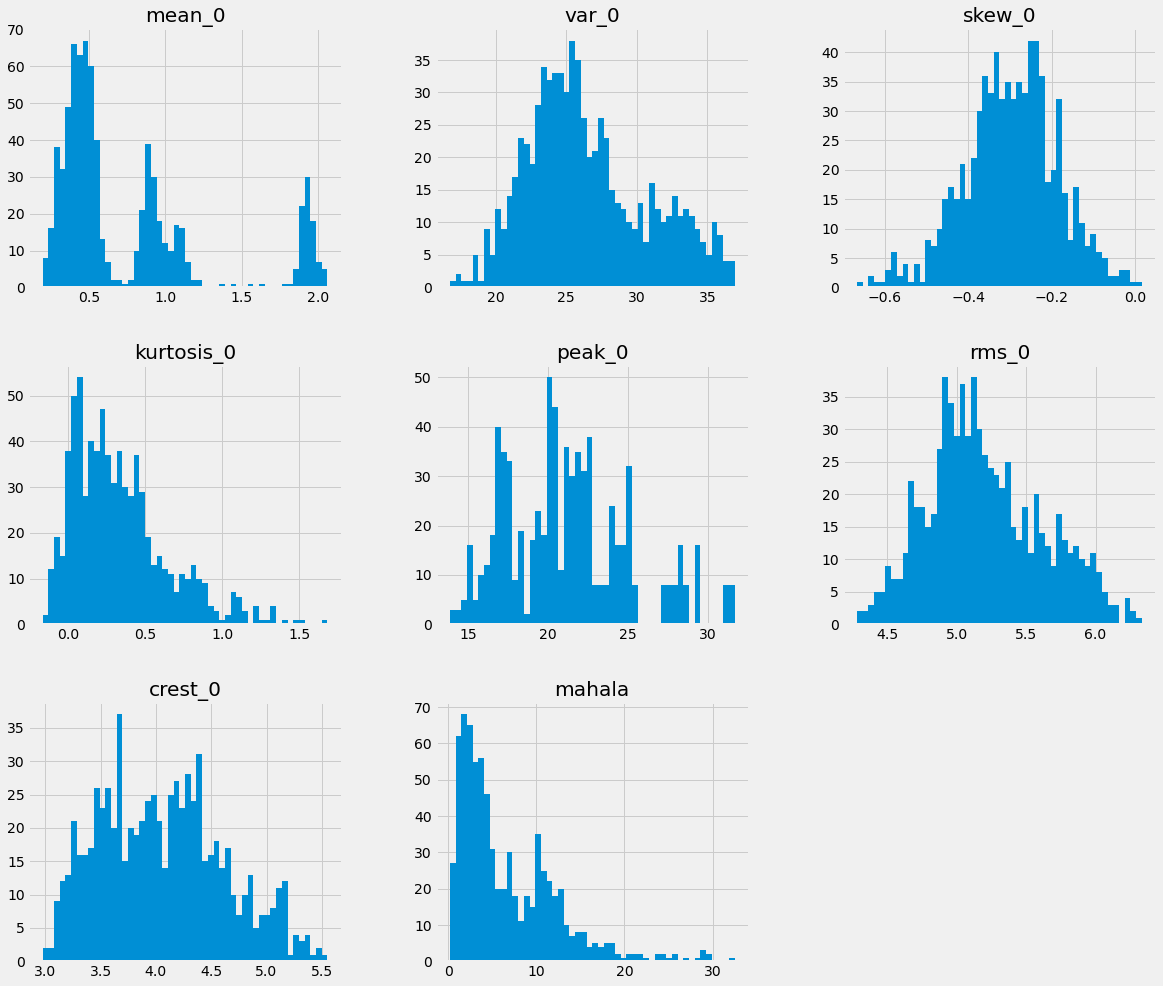

In [32]:
plt.style.use('fivethirtyeight')
ax = df_RR_RH['mahala'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('Mahalanobis Distance for RR_RH Sensor for Feb Testing Data', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(125, color='k', linestyle='--')
ax.legend(("Test1 (Feb)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

df_FR_LH.hist(bins=50, figsize=(18,16))
plt.show()

# Mahalanobis distance calculation for test set 1 for Cabin sensor comparing with mean and covariance values of train (reference) sett

In [33]:
df_Cabin = data_new_Cabin[['mean_4', 'var_4', 'skew_4', 'kurtosis_4', 'peak_4', 'rms_4', 'crest_4']]
df_Cabin['mahala'] = mahalanobis(x=df_Cabin, data=data_vib_Cabin[['mean_4', 'var_4', 'skew_4', 'kurtosis_4', 'peak_4', 'rms_4', 'crest_4']])
df_Cabin = pd.concat([data_new_Cabin['DateTime'], df_Cabin], axis =1)
df_Cabin_asc = df_Cabin.sort_values(by=['mahala'], ascending=False)
df_Cabin_asc

C:\Users\Khyati.Thakkar\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


DateTime    mean_4      var_4    skew_4  kurtosis_4  \
158749  2020-02-25 16:52:41.450 -0.097344  27.473504 -0.408659    0.167656   
155749  2020-02-25 16:52:26.450 -0.071822  13.348964 -0.215272    0.142305   
159249  2020-02-25 16:52:43.950 -0.096834  27.163152 -0.395124    0.187861   
158999  2020-02-25 16:52:42.700 -0.101008  27.187980 -0.408023    0.210108   
64999   2020-02-25 15:32:08.640  0.254777  27.841334 -0.326373    0.026486   
...                         ...       ...        ...       ...         ...   
94249   2020-02-25 16:08:13.355  0.070272  17.238523 -0.216010    0.377148   
93749   2020-02-25 16:08:10.855  0.131737  18.507709 -0.240219    0.273897   
121749  2020-02-25 16:32:28.320  0.040605  19.199046 -0.262367    0.384050   
10249   2020-02-25 15:04:09.715  0.114364  19.939529 -0.294147    0.314124   
84499   2020-02-25 15:45:28.940  0.080536  18.898031 -0.220780    0.307001   

           peak_4     rms_4   crest_4     mahala  
158749  23.275867  5.241111  4.441018  35.092667  
155749  12.214895  3.653416  3.343418  33.260707  
159249  23.275867  5.211425  4.466316  32.572067  
158999  23.275867  5.213884  4.464209  32.200867  
64999   18.968252  5.281318  3.591575  26.113793  
...           ...       ...       ...        ...  
94249   17.850113  4.151487  4.299692   1.228320  
93749   17.850113  4.303000  4.148295   1.225266  
121749  18.228170  4.380764  4.160957   1.164195  
10249   19.317566  4.465718  4.325747   0.998614  
84499   18.728010  4.346846  4.308414   0.974867  

[743 rows x 9 columns]

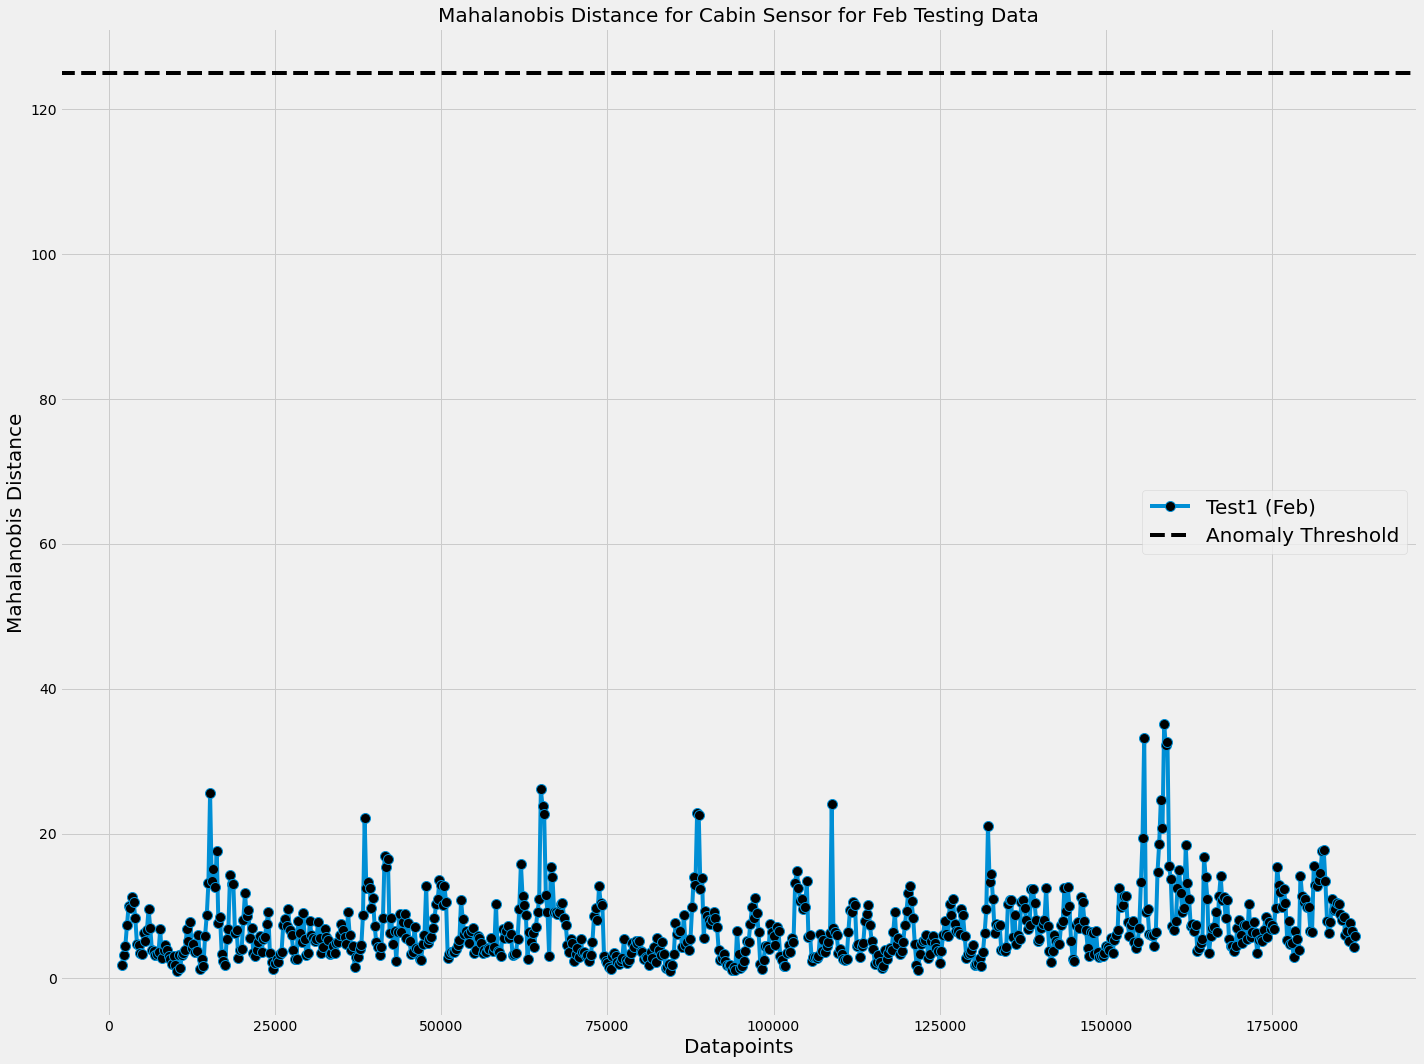

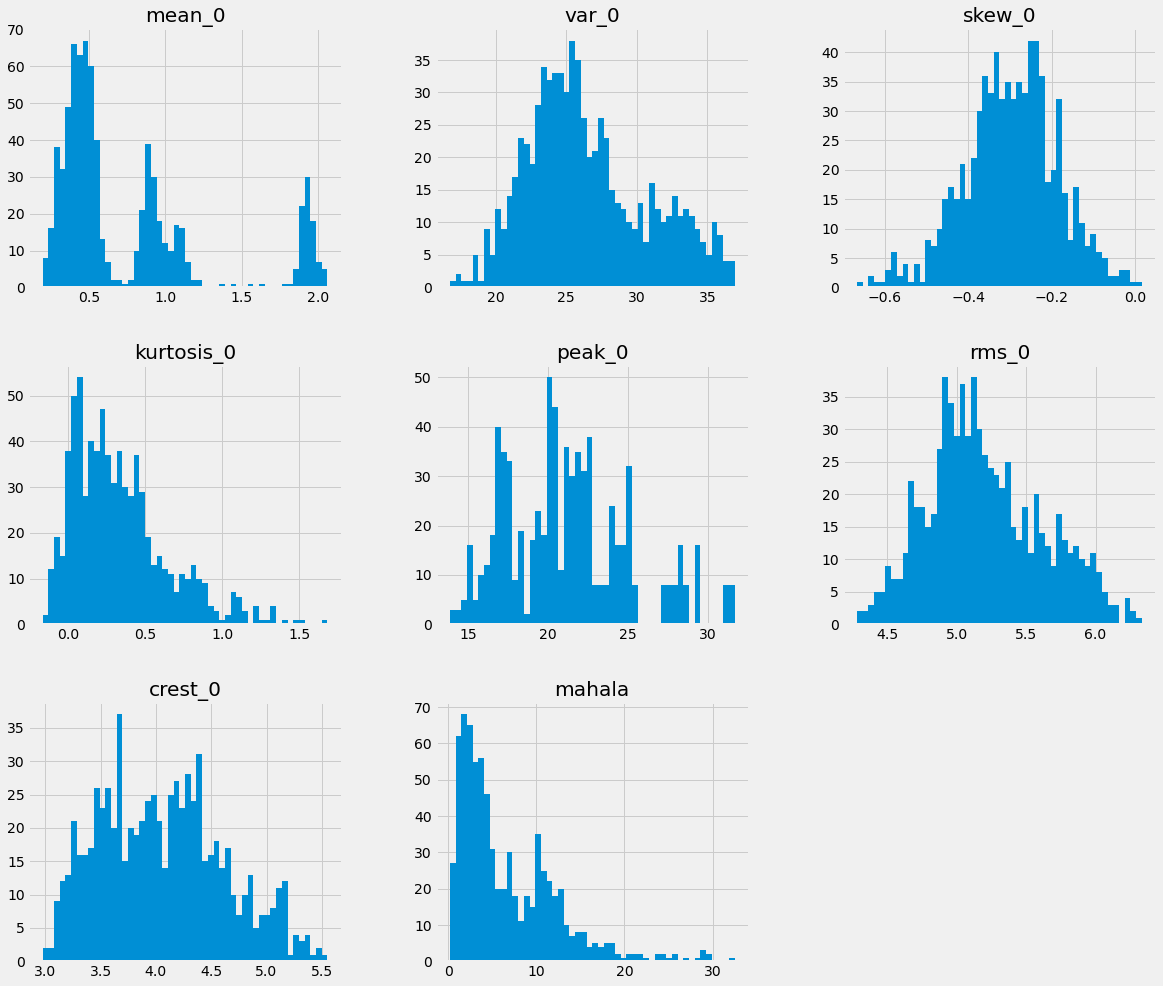

In [34]:
plt.style.use('fivethirtyeight')
ax = df_Cabin['mahala'].plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('Mahalanobis Distance for Cabin Sensor for Feb Testing Data', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(125, color='k', linestyle='--')
ax.legend(("Test1 (Feb)", "Anomaly Threshold"), fontsize=20)
plt.tight_layout()

df_FR_LH.hist(bins=50, figsize=(18,16))
plt.show()

# Mahalanobis distance calculation visualization for test set 1 for all sensors

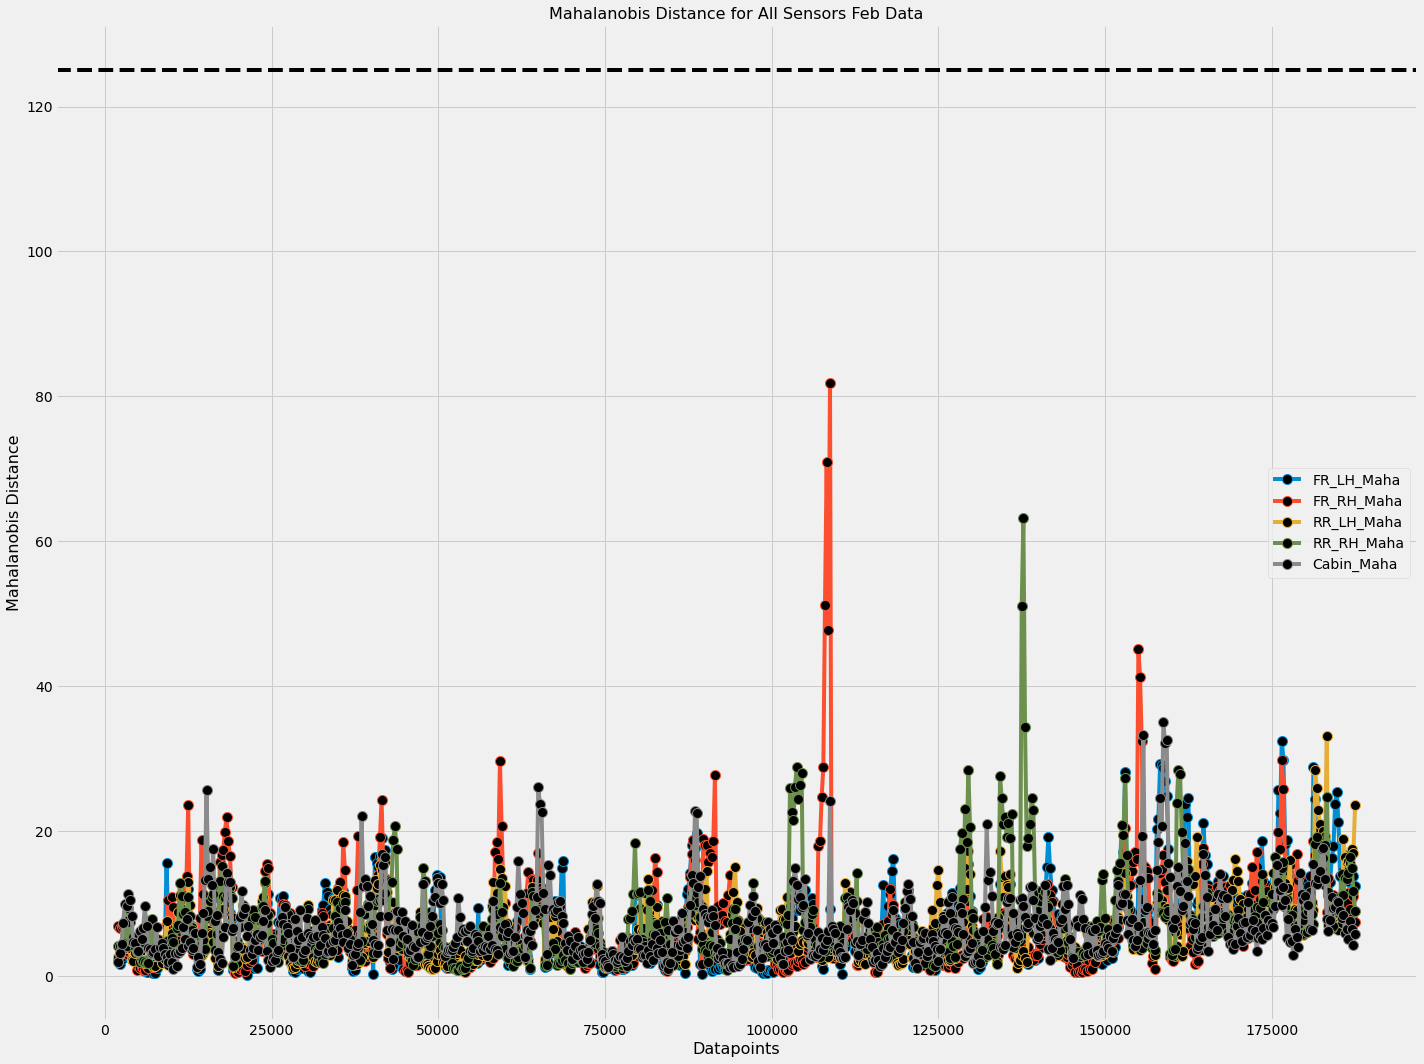

In [36]:
plt.style.use('fivethirtyeight')
feb_comb = pd.concat([df_FR_LH['mahala'],df_FR_RH['mahala'],df_RR_LH['mahala'],df_RR_RH['mahala'],df_Cabin['mahala']], axis=1)
feb_comb.columns = ['FR_LH_Maha','FR_RH_Maha','RR_LH_Maha','RR_RH_Maha','Cabin_Maha']
ax = feb_comb.plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=16)
ax.set_ylabel('Mahalanobis Distance', fontsize=16)
ax.set_title('Mahalanobis Distance for All Sensors Feb Data', fontsize=16)

plt.axhline(125, color='k', linestyle='--')
plt.tight_layout()

In [72]:
feb_comb.to_csv("Output_Data_Files/MahaDist_Rough_Feb.csv")
feb_comb

FR_LH_Maha  FR_RH_Maha  RR_LH_Maha  RR_RH_Maha  Cabin_Maha
1999      2.459876    6.898124    2.644979    4.177030    1.910837
2249      1.658935    6.735705    3.143197    4.120125    3.256506
2499      2.387452    6.740093    4.194363    4.062399    4.447735
2749      2.833269    7.074426    4.338581    4.598594    7.366878
2999      7.205658    4.278219    5.798966    7.694778   10.009597
...            ...         ...         ...         ...         ...
186499   13.178532   11.478628   15.908834   14.271652    5.210072
186749   11.523010    9.230508   15.659104   16.444602    7.664995
186999   10.806718    8.002019   17.595388   14.977217    6.485948
187249   13.783670   11.109128   17.056329   11.790069    4.337337
187499   12.486111    7.433151   23.679056    8.993424    5.877627

[743 rows x 5 columns]

# Similar analysis is done for March data refered to as test2 data to derive mahalanobis distances for each sensor values in test 2 dataset and is used in further analysis for comparison between test 1 and test 2 datasets

# Compare & plot mahalanobis distances for both test sets (test 1 & test 2)

In [73]:
test1 = pd.read_csv('Output_Data_Files/MahaDist_Rough_Feb.csv', index_col=0)
test1

FR_LH_Maha  FR_RH_Maha  RR_LH_Maha  RR_RH_Maha  Cabin_Maha
1999      2.459876    6.898124    2.644979    4.177030    1.910837
2249      1.658935    6.735705    3.143197    4.120125    3.256506
2499      2.387452    6.740093    4.194363    4.062399    4.447735
2749      2.833269    7.074426    4.338581    4.598594    7.366878
2999      7.205658    4.278219    5.798966    7.694778   10.009597
...            ...         ...         ...         ...         ...
186499   13.178532   11.478628   15.908834   14.271652    5.210072
186749   11.523010    9.230508   15.659104   16.444602    7.664995
186999   10.806718    8.002019   17.595388   14.977217    6.485948
187249   13.783670   11.109128   17.056329   11.790069    4.337337
187499   12.486111    7.433151   23.679056    8.993424    5.877627

[743 rows x 5 columns]

In [74]:
test2=pd.read_csv('Output_Data_Files/MahaDist_Rough_March.csv', index_col=0)
test2

FR_LH_Maha  FR_RH_Maha  RR_LH_Maha  RR_RH_Maha  Cabin_Maha
1999      28.370788   46.136515   23.364009   20.598810   21.043334
2249      12.592997   17.267171   19.826166   16.974706   19.947411
2499      10.938882   14.695529   17.395894   18.010794   17.773265
2749       7.326585   12.821544   16.704130   15.021408   21.004246
2999       8.100547   15.361617   17.774824   17.772246   22.183977
...             ...         ...         ...         ...         ...
185499  1558.248400  258.907424   34.043038   93.839584   17.366380
185749  1576.661712  266.392384   35.230474   85.988119   19.771048
185999  1598.680352  271.621747   35.068904   80.298921   16.599001
186249  1550.713723  239.520946   31.340876   81.291730   25.881299
186499  1654.008945  279.986375   29.452057   81.981729   20.870419

[739 rows x 5 columns]

In [40]:
Maha_both = pd.concat([test1,test2], axis=1)
Maha_both.columns = ['FR_LH_Feb','FR_RH_Feb','RR_LH_Feb','RR_RH_Feb','Cabin_Feb','FR_LH_March','FR_RH_March','RR_LH_March','RR_RH_March','Cabin_March']
Maha_both

FR_LH_Feb  FR_RH_Feb  RR_LH_Feb  RR_RH_Feb  Cabin_Feb  FR_LH_March  \
1999     2.459876   6.898124   2.644979   4.177030   1.910837    28.370788   
2249     1.658935   6.735705   3.143197   4.120125   3.256506    12.592997   
2499     2.387452   6.740093   4.194363   4.062399   4.447735    10.938882   
2749     2.833269   7.074426   4.338581   4.598594   7.366878     7.326585   
2999     7.205658   4.278219   5.798966   7.694778  10.009597     8.100547   
...           ...        ...        ...        ...        ...          ...   
186499  13.178532  11.478628  15.908834  14.271652   5.210072  1654.008945   
186749  11.523010   9.230508  15.659104  16.444602   7.664995          NaN   
186999  10.806718   8.002019  17.595388  14.977217   6.485948          NaN   
187249  13.783670  11.109128  17.056329  11.790069   4.337337          NaN   
187499  12.486111   7.433151  23.679056   8.993424   5.877627          NaN   

        FR_RH_March  RR_LH_March  RR_RH_March  Cabin_March  
1999      46.136515    23.364009    20.598810    21.043334  
2249      17.267171    19.826166    16.974706    19.947411  
2499      14.695529    17.395894    18.010794    17.773265  
2749      12.821544    16.704130    15.021408    21.004246  
2999      15.361617    17.774824    17.772246    22.183977  
...             ...          ...          ...          ...  
186499   279.986375    29.452057    81.981729    20.870419  
186749          NaN          NaN          NaN          NaN  
186999          NaN          NaN          NaN          NaN  
187249          NaN          NaN          NaN          NaN  
187499          NaN          NaN          NaN          NaN  

[743 rows x 10 columns]

# Plot mahalanobis distances for both test sets (test 1 & test 2) for all sensors

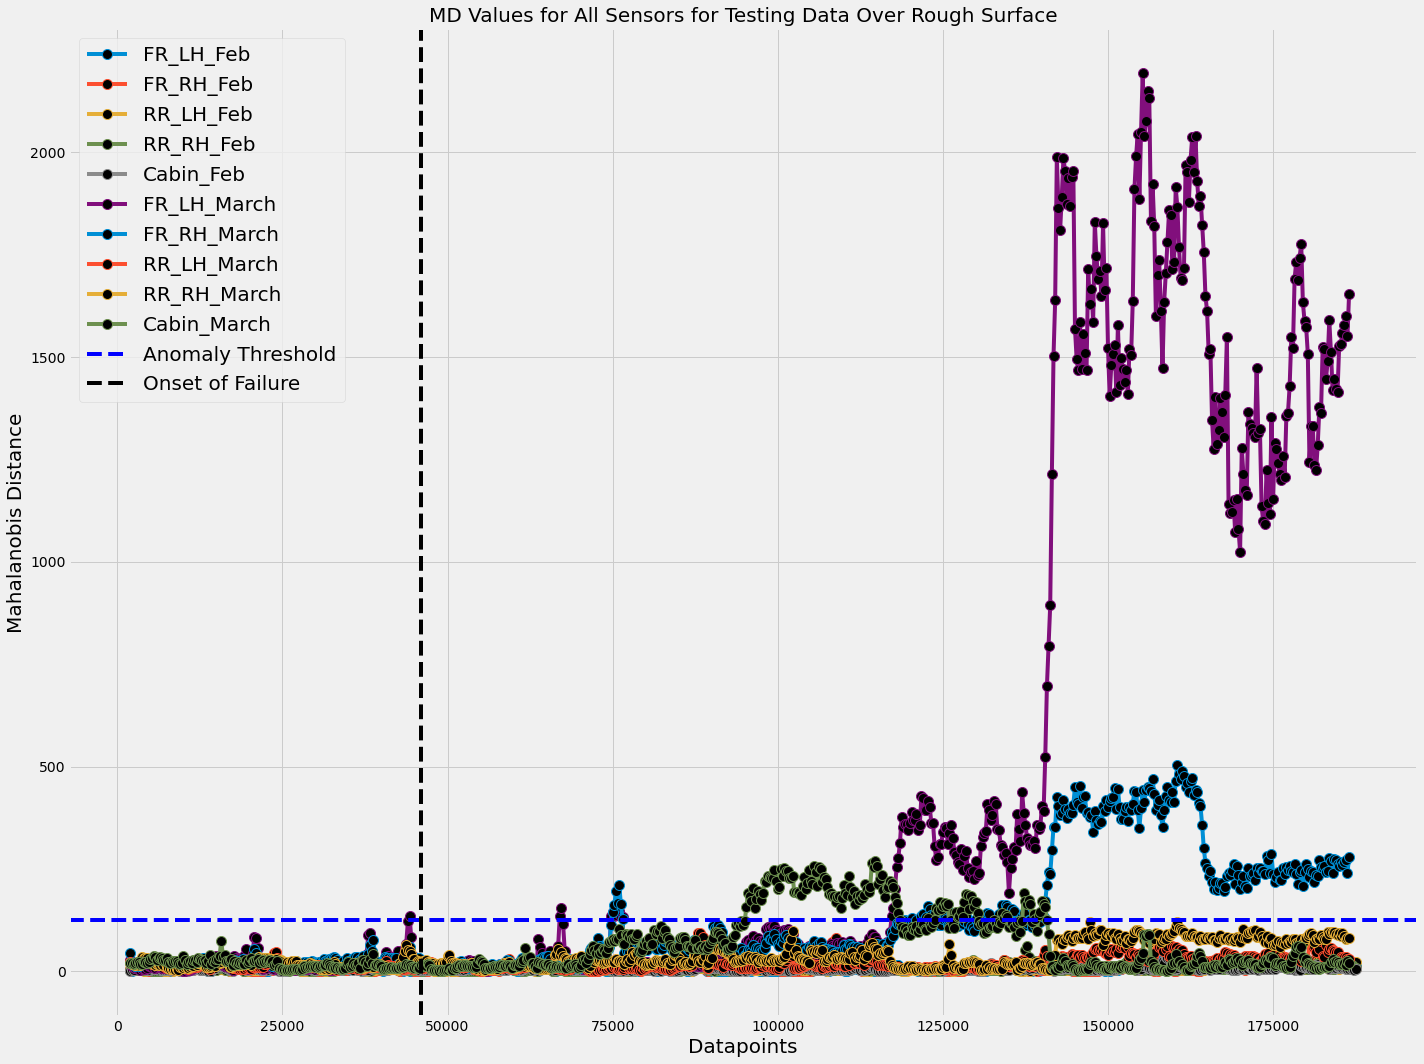

In [41]:
plt.style.use('fivethirtyeight')
ax = Maha_both.plot(figsize=(20,15), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('MD Values for All Sensors for Testing Data Over Rough Surface', fontsize=20)
plt.axhline(125, color='blue', linestyle='--', label="threshold")
plt.axvline(46040, color='black', linestyle='--', label="failure")
ax.legend(("FR_LH_Feb", "FR_RH_Feb", "RR_LH_Feb", "RR_RH_Feb", "Cabin_Feb", "FR_LH_March", "FR_RH_March", "RR_LH_March", "RR_RH_March", "Cabin_March", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()

# Plot mahalanobis distances for both test sets (test 1 & test 2) for individual sensors

In [42]:
test_FR_LH = pd.concat([Maha_both['FR_LH_Feb'],Maha_both['FR_LH_March']], axis=1)
test_FR_LH.columns = ['Test1 (Feb)', 'Test2 (March)']

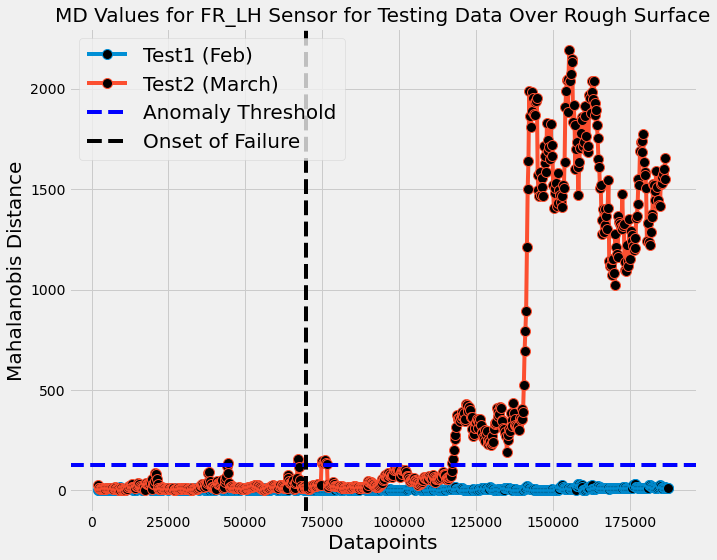

In [52]:
plt.style.use('fivethirtyeight')
ax = test_FR_LH.plot(figsize=(10,8), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('MD Values for FR_LH Sensor for Testing Data Over Rough Surface', fontsize=20)
plt.axhline(125, color='blue', linestyle='--', label="threshold")
plt.axvline(69849, color='black', linestyle='--', label="failure")
ax.legend(("Test1 (Feb)", "Test2 (March)", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()

In [44]:
test_FR_RH = pd.concat([Maha_both['FR_RH_Feb'],Maha_both['FR_RH_March']], axis=1)
test_FR_RH.columns = ['Test1 (Feb)', 'Test2 (March)']

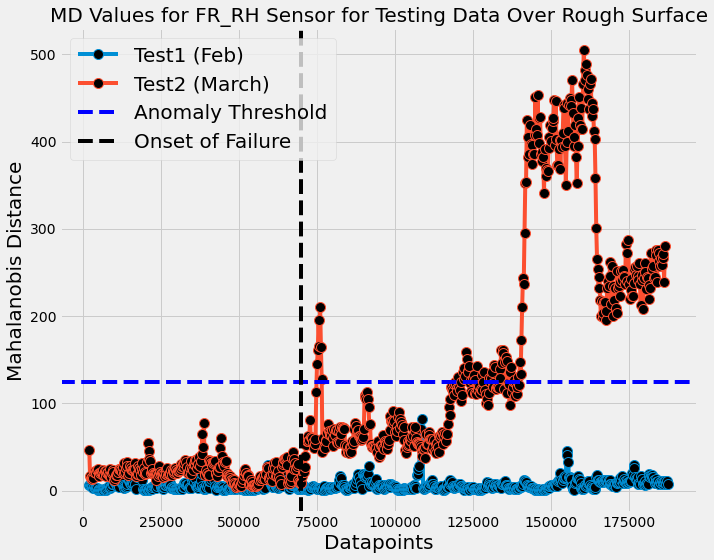

In [53]:
plt.style.use('fivethirtyeight')
ax = test_FR_RH.plot(figsize=(10,8), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('MD Values for FR_RH Sensor for Testing Data Over Rough Surface', fontsize=20)
plt.axhline(125, color='blue', linestyle='--', label="threshold")
plt.axvline(69849, color='black', linestyle='--', label="failure")
ax.legend(("Test1 (Feb)", "Test2 (March)", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()

In [46]:
test_RR_LH = pd.concat([Maha_both['RR_LH_Feb'],Maha_both['RR_LH_March']], axis=1)
test_RR_LH.columns = ['Test1 (Feb)', 'Test2 (March)']

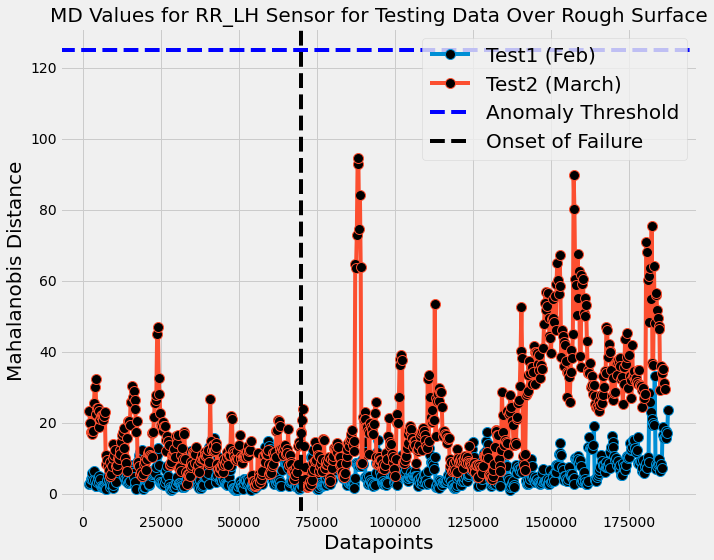

In [54]:
plt.style.use('fivethirtyeight')
ax = test_RR_LH.plot(figsize=(10,8), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('MD Values for RR_LH Sensor for Testing Data Over Rough Surface', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(125, color='blue', linestyle='--')
plt.axvline(69849, color='black', linestyle='--')
ax.legend(("Test1 (Feb)", "Test2 (March)", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()

In [48]:
test_RR_RH = pd.concat([Maha_both['RR_RH_Feb'],Maha_both['RR_RH_March']], axis=1)
test_RR_RH.columns = ['Test1 (Feb)', 'Test2 (March)']

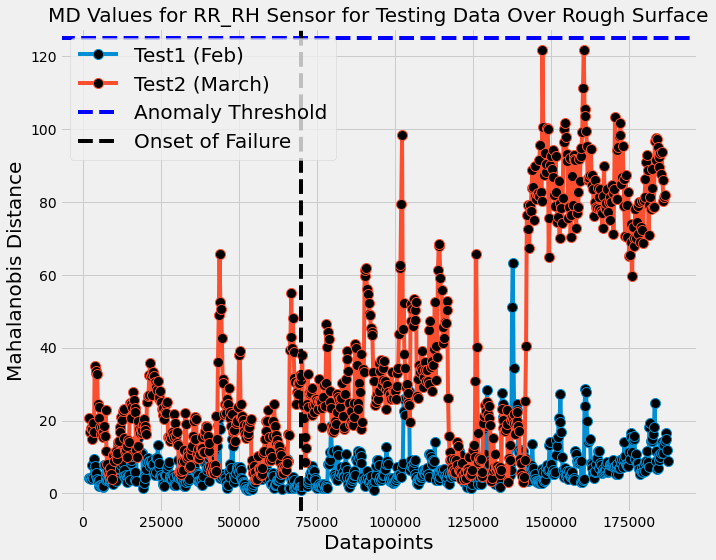

In [55]:
plt.style.use('fivethirtyeight')
ax = test_RR_RH.plot(figsize=(10,8), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('MD Values for RR_RH Sensor for Testing Data Over Rough Surface', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(125, color='blue', linestyle='--')
plt.axvline(69849, color='black', linestyle='--')
ax.legend(("Test1 (Feb)", "Test2 (March)", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()

In [50]:
test_Cabin = pd.concat([Maha_both['Cabin_Feb'],Maha_both['Cabin_March']], axis=1)
test_Cabin.columns = ['Test1 (Feb)', 'Test2 (March)']

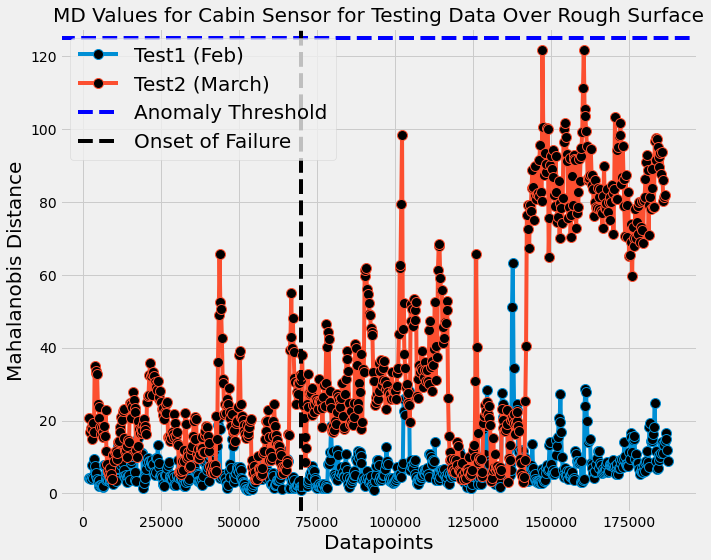

In [56]:
plt.style.use('fivethirtyeight')
ax = test_RR_RH.plot(figsize=(10,8), marker='o', markersize=10, markerfacecolor='black')
ax.set_xlabel('Datapoints', fontsize=20)
ax.set_ylabel('Mahalanobis Distance', fontsize=20)
ax.set_title('MD Values for Cabin Sensor for Testing Data Over Rough Surface', fontsize=20)
ax.legend(fontsize=20)
plt.axhline(125, color='blue', linestyle='--')
plt.axvline(69849, color='black', linestyle='--')
ax.legend(("Test1 (Feb)", "Test2 (March)", "Anomaly Threshold", "Onset of Failure"), fontsize=20)
plt.tight_layout()